### Python - Bootcamp IA 

Uma empresa do setor siderúrgico contratou você para a criação de um sistema inteligente 
de controle de qualidade para chapas de aço inoxidável. Essa empresa forneceu um conjunto 
de dados contendo informações extraídas a partir de imagens de superfície das chapas, com 
o objetivo de detectar e classificar defeitos automaticamente. Cada amostra no conjunto de 
dados é composta por 31 indicadores que descrevem aspectos geométricos e estatísticos do 
defeito identificado, como área, perímetro, índices de orientação, luminosidade e proporção 
de bordas. Além dessas características, cada amostra é rotulada com uma das sete possíveis 
classes de defeitos (seis categorias específicas e uma categoria genérica de “outros 
defeitos”). 
O sistema deverá ser capaz de, a partir do cadastro de uma nova imagem (ou conjunto de 
medições), prever a classe do defeito e retornar a probabilidade associada. Além disso, a 
empresa espera que você extraia insights da operação e dos defeitos e gere visualizações de 
dados.

In [287]:
# Caso precise instalar as bibliotecas
# %pip install xgboost
# %pip install scikit-learn
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install xgboost

In [288]:
# Passo a Passo
# Passo 1 : Importar base de dados teste
# Passo 2 : Visualizar a base de dados
# Passo 3 : Corrigir os valores,colunas que não serão usadas, os Dtypes e normalizar valores (ex: True ou False)
# Passo 4 : Corrigir as linhas que contém nulos
# Passo 5 : Análise das falhas
# Passo 6 : Análise dos outliers
# Passo 7 : Remover outliers
# Passo 8 : Análise sem outliers
# Passo 9 : Criar um modelo
# Passo 10 : treina o modelo
# Passo 11 : verifica se o modelo teve um bom desempenho
# Passo 12 : Testar o modelo


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import zscore

## Importar a base de dados

In [289]:
tabela_train = pd.read_csv("bootcamp_train.csv")

## Visualizar e analisar os dados da tabela

verificar inconsistencias da tabela

In [290]:
tabela_train.sample(10)

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,...,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros
1849,1849,1127,1139.0,-20,-166,100,16,13,10,1990.0,...,-0.2395,0.1696,84,False,False,False,nao,Não,False,Sim
3187,3187,-11,567.0,966871,966930,100,-206,-229,13,NaN,...,-0.1788,0.2018,99,False,True,False,False,não,False,Não
2841,2841,919,929.0,113839,113846,100,85,15,11,8602.0,...,-0.5754,0.2173,21,False,False,False,False,Não,True,Não
2684,2684,853,861.0,-20,1564476,100,-206,26,39,33449.0,...,-0.1827,0.8299,84,nao,False,False,False,Não,False,Sim
1396,1396,1331,1344.0,397980,398111,100,788,67,137,65200.0,...,-0.3536,0.9999,529,False,False,False,False,Não,False,Sim
682,682,41,60.0,3824786,3824807,100,287,27,23,21603.0,...,-0.4119,0.6559,27,False,False,False,False,Não,True,Não
1176,1176,799,804.0,12701627,1341296,100,12,-229,4,1504.0,...,-0.0208,0.1322,111,False,False,False,True,Não,False,Não
2096,2096,5847,1163.0,902188,902203,100,235,24,32,23207.0,...,-0.0924,0.6330,108,False,False,False,False,Não,False,Sim
1885,1885,-11,1688.0,778450,778465,100,-206,34,35,32134.0,...,-0.1776,0.6330,96,False,False,False,False,Não,True,Não
1465,1465,847,-186.0,3658081,3658092,100,84,15,11,8532.0,...,-0.2065,0.2300,83,False,False,False,False,não,True,Não


In [291]:
tabela_train.tail()

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,...,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros
3385,3385,779,802.0,402237,402266,100,755,177,17,764.0,...,-0.1026,1.0000,103,False,False,False,False,não,True,Não
3386,3386,41,188.0,327823,327870,100,3437,248,116,354240.0,...,-0.1749,1.0000,42,0,False,False,False,não,False,Sim
3387,3387,823,834.0,323844,323852,100,135,20,-194,14169.0,...,-0.1264,0.3977,97,False,False,False,False,Não,True,Não
3388,3388,9505,-186.0,949856,949874,100,-206,29,26,NaN,...,-0.0238,0.8355,116,False,0,False,False,Não,False,Sim
3389,3389,1181,1191.0,1146871,1146879,100,12,5,5,1585.0,...,-0.0022,0.1400,120,False,False,False,False,Não,False,Sim


Verificar os Dtypes

In [292]:
tabela_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3390 non-null   int64  
 1   x_minimo                      3390 non-null   int64  
 2   x_maximo                      3334 non-null   float64
 3   y_minimo                      3390 non-null   int64  
 4   y_maximo                      3390 non-null   int64  
 5   peso_da_placa                 3390 non-null   int64  
 6   area_pixels                   3390 non-null   int64  
 7   perimetro_x                   3390 non-null   int64  
 8   perimetro_y                   3390 non-null   int64  
 9   soma_da_luminosidade          3290 non-null   float64
 10  maximo_da_luminosidade        3292 non-null   float64
 11  comprimento_do_transportador  3390 non-null   int64  
 12  tipo_do_aço_A300              3390 non-null   object 
 13  tip

### Verificar a existencia de linhas duplicadas

In [293]:
tabela_train[tabela_train.duplicated()]


,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,...,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros


### Verificar quantidade de linhas e colunas

In [294]:
tabela_train.shape

(3390, 39)

### Verificar valores unicos presentes na tabela

In [295]:
tabela_train.nunique()

id                              3390
x_minimo                        1136
x_maximo                         945
y_minimo                        2017
y_maximo                        1809
peso_da_placa                      1
area_pixels                      850
perimetro_x                      363
perimetro_y                      294
soma_da_luminosidade            1783
maximo_da_luminosidade            91
comprimento_do_transportador      83
tipo_do_aço_A300                   8
tipo_do_aço_A400                   8
espessura_da_chapa_de_aço         24
temperatura                     3390
index_de_bordas                 1347
index_vazio                     1286
index_quadrado                   745
index_externo_x                  433
indice_de_bordas_x               778
indice_de_bordas_y               618
indice_de_variacao_x            3390
indice_de_variacao_y            3390
indice_global_externo              3
log_das_areas                    862
log_indice_x                     177
l

### Contar quantos nulos por coluna

In [296]:
display(tabela_train.isnull().sum())

id                                0
x_minimo                          0
x_maximo                         56
y_minimo                          0
y_maximo                          0
peso_da_placa                     0
area_pixels                       0
perimetro_x                       0
perimetro_y                       0
soma_da_luminosidade            100
maximo_da_luminosidade           98
comprimento_do_transportador      0
tipo_do_aço_A300                  0
tipo_do_aço_A400                 76
espessura_da_chapa_de_aço        41
temperatura                       0
index_de_bordas                   0
index_vazio                       0
index_quadrado                   36
index_externo_x                   0
indice_de_bordas_x                0
indice_de_bordas_y                0
indice_de_variacao_x              0
indice_de_variacao_y              0
indice_global_externo            59
log_das_areas                     0
log_indice_x                      0
log_indice_y                

### Dividi a tabela por Dtypes para melhor visualização

In [297]:
# Verificar se os Dtypes estão corretos
type_int = tabela_train.select_dtypes(include=int)
type_float = tabela_train.select_dtypes(include=float)
type_object = tabela_train.select_dtypes(include=object)

type_int.sample(10)


,id,x_minimo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,comprimento_do_transportador,minimo_da_luminosidade
1378,1378,575,1188740,1188745,100,17,8,5,1358,105
2908,2908,-11,414919,414931,100,64,11,17,1352,110
3362,3362,41,7868566,1147880,100,6653,247,131,1358,42
3314,3314,317,1436089,1436092,100,57,-229,10,1358,100
1669,1669,1053,6265848,808199,100,110,25,26,1353,90
2887,2887,971,1294504,1294539,100,89,12,13,-214,148
3074,3074,81,7307739,-166,100,3661,157,-194,1362,50
377,377,950,2304542,2304550,100,119,30,12,1356,110
713,713,141,133683,133829,100,2267,201,161,1354,96
2233,2233,651,933641,933675,100,102,9,11,-214,123


In [298]:
type_float.sample(30)


,x_maximo,soma_da_luminosidade,maximo_da_luminosidade,espessura_da_chapa_de_aço,temperatura,index_de_bordas,index_vazio,index_quadrado,index_externo_x,indice_de_bordas_x,indice_de_bordas_y,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas
1996,466.0,12221.0,126.0,40.0,90.685020,0.5397,0.2714,1.0000,0.0087,0.7500,1.0000,-0.007956,-0.007956,0.5,2.0334,1.0792,1.1761,0.0000,-0.0902,0.2914
2665,-186.0,18067.0,124.0,80.0,79.304598,0.7931,0.3636,0.6111,0.0081,0.8461,1.0000,-0.410141,-0.410141,1.0,2.2279,1.0414,1.2553,0.3889,-0.1706,0.3329
554,20.0,14835.0,124.0,-154.0,75.841063,0.0131,0.3939,0.5238,0.0080,0.8461,0.9130,0.101281,0.101281,1.0,2.1461,1.0414,1.3222,0.4762,-0.1722,0.3834
91,-186.0,674367.0,124.0,40.0,87.243568,0.0574,0.4285,0.3815,0.1274,0.6223,0.4925,0.290593,1.290593,0.0,3.8146,2.2380,1.8195,-0.6185,-0.1926,1.0000
2223,1642.0,8586.0,94.0,70.0,85.583085,0.0455,0.3750,0.9231,0.0052,0.6364,1.0000,-0.054367,-0.054367,1.0,1.9138,0.8451,1.1139,0.0769,-0.5811,0.2583
2155,686.0,7873.0,119.0,90.0,86.107469,0.9575,0.5069,0.7500,0.0066,0.7500,1.0000,-0.184908,-0.184908,1.0,1.8573,0.9542,1.0792,0.2500,-0.2081,0.2583
557,179.0,17898.0,141.0,-154.0,77.772406,0.2309,0.4697,0.5454,0.0162,0.5116,0.9231,-0.129767,-0.129767,0.0,2.1461,1.3424,1.0792,-0.4545,-0.0012,0.4366
1815,631.0,NaN,125.0,100.0,84.391075,0.9106,0.4368,0.2308,0.0088,0.2381,0.9259,-0.267358,-0.267358,1.0,2.6484,1.0792,1.7482,0.7692,-0.1797,0.9809
3207,521.0,11861.0,127.0,70.0,91.942574,0.6052,0.2361,1.0000,0.0071,0.8571,1.0000,0.664429,1.052613,0.5,2.0043,1.0792,1.1139,0.0000,-0.1984,0.2583
1321,1169.0,7164.0,135.0,150.0,71.759299,0.6166,0.1750,0.8000,0.0059,0.8333,1.0000,0.158908,0.158908,0.0,1.8195,1.0000,0.9031,-0.2000,-0.1520,0.1852


In [299]:
type_object.sample(30)

,tipo_do_aço_A300,tipo_do_aço_A400,falha_1,falha_2,falha_4,falha_5,falha_outros
174,Não,Sim,False,0,False,Não,Sim
1903,Sim,Não,False,False,False,Não,Não
57,Não,sim,False,False,False,Não,Sim
939,N,Sim,False,False,False,não,Não
1469,Sim,Não,False,1,False,Não,Não
1714,Não,Sim,False,False,False,não,Não
373,sim,não,False,False,False,não,Não
201,sim,Não,False,True,False,não,Não
1735,Sim,Não,False,False,False,não,Sim
249,Não,sim,False,False,False,Não,Sim


### Excluir colunas que não serão usadas

In [300]:
tabela_train = tabela_train.drop(["id", "y_minimo", "y_maximo", "peso_da_placa"], axis=1) 
# ID pois não vamos usar pra o treinamento do modelo
# Todas as chapas de aço tem o mesmo peso (pode afetar o modelo com "ruidos")
# y_minimo, y_maximo estão com valores muito fora do normal

### Funsão criada para remover os nulos pela média
os valores que não podem ser substituido pela média foram removidos (ex: falha_1)

In [301]:
def remover_nulos(df, coluna) :
    df[coluna] = df[coluna].fillna(df[coluna].median())
    return df

tabela_train = remover_nulos(tabela_train, "x_maximo")
tabela_train = remover_nulos(tabela_train, "soma_da_luminosidade")
tabela_train = remover_nulos(tabela_train, "maximo_da_luminosidade")
tabela_train = remover_nulos(tabela_train, "espessura_da_chapa_de_aço")
tabela_train = remover_nulos(tabela_train, "index_quadrado")
tabela_train = remover_nulos(tabela_train, "indice_global_externo")
tabela_train = tabela_train.dropna()



### Analisar quantas linhas restaram depois de remover os valores nulos

In [302]:
tabela_train.shape

(3264, 35)

### Verificar se os valores nulos foram removidos

In [303]:
display(tabela_train.isnull().sum())

x_minimo                        0
x_maximo                        0
area_pixels                     0
perimetro_x                     0
perimetro_y                     0
soma_da_luminosidade            0
maximo_da_luminosidade          0
comprimento_do_transportador    0
tipo_do_aço_A300                0
tipo_do_aço_A400                0
espessura_da_chapa_de_aço       0
temperatura                     0
index_de_bordas                 0
index_vazio                     0
index_quadrado                  0
index_externo_x                 0
indice_de_bordas_x              0
indice_de_bordas_y              0
indice_de_variacao_x            0
indice_de_variacao_y            0
indice_global_externo           0
log_das_areas                   0
log_indice_x                    0
log_indice_y                    0
indice_de_orientaçao            0
indice_de_luminosidade          0
sigmoide_das_areas              0
minimo_da_luminosidade          0
falha_1                         0
falha_2       

### Corrigir os Dtypes da tabela

In [304]:
tabela_train["x_maximo"] = tabela_train["x_maximo"].astype(int)
tabela_train["maximo_da_luminosidade"] = tabela_train["maximo_da_luminosidade"].astype(int)
tabela_train["soma_da_luminosidade"] = tabela_train["soma_da_luminosidade"].astype(int)
tabela_train["espessura_da_chapa_de_aço"] = tabela_train["espessura_da_chapa_de_aço"].astype(int)

tabela_train["x_maximo"].info()
tabela_train["maximo_da_luminosidade"].info()

<class 'pandas.core.series.Series'>
Index: 3264 entries, 0 to 3389
Series name: x_maximo
Non-Null Count  Dtype
--------------  -----
3264 non-null   int64
dtypes: int64(1)
memory usage: 51.0 KB
<class 'pandas.core.series.Series'>
Index: 3264 entries, 0 to 3389
Series name: maximo_da_luminosidade
Non-Null Count  Dtype
--------------  -----
3264 non-null   int64
dtypes: int64(1)
memory usage: 51.0 KB


### Verificar se os dados de True ou False estão normalizados

In [305]:

print(f"Falha 1: {tabela_train["falha_1"].unique()}")
print(f"Falha 2: {tabela_train["falha_2"].unique()}")
print(f"Falha 3: {tabela_train["falha_3"].unique()}")
print(f"Falha 4: {tabela_train["falha_4"].unique()}")
print(f"Falha 5: {tabela_train["falha_5"].unique()}")
print(f"Falha 6: {tabela_train["falha_6"].unique()}")
print(f"Falha outros: {tabela_train["falha_outros"].unique()}")
print(f"Tipo do aço A300: {tabela_train["tipo_do_aço_A300"].unique()}")
print(f"Tipo do aço A400: {tabela_train["tipo_do_aço_A400"].unique()}")


Falha 1: ['False' '0' '1' 'True' 'nao' 'S']
Falha 2: ['0' 'False' 'True' 'y' '1' 'S']
Falha 3: [False  True]
Falha 4: ['False' 'True' 'nao' '0' 'S' '1']
Falha 5: ['não' 'Não' 'Sim' 'sim']
Falha 6: [False  True]
Falha outros: ['Sim' 'Não']
Tipo do aço A300: ['Não' 'não' '1' 'Sim' 'sim' '0' 'N' '-']
Tipo do aço A400: ['sim' 'Sim' 'Não' 'não' '1' '0' 'S' 'nao']


### Normalizar as dados True e False para 1 e 0

In [306]:

def corrigir_true_false(df, coluna) :
    correcoes = {
    "0" : 0,
    "nao" : 0,
    "não" : 0,
    "Não" : 0,
    "FALSE" : 0,
    "False" : 0,
    False : 0,
    "N" : 0,
    "1" : 1,
    "S" : 1,
    "y" : 1,
    "Sim" : 1,
    "sim" : 1,
    "TRUE" : 1,
    "True" : 1,
    True : 1
    }

    df[coluna] = df[coluna].replace(correcoes)
    return df


tabela_train = corrigir_true_false(tabela_train, "falha_1")
tabela_train = corrigir_true_false(tabela_train, "falha_2")
tabela_train = corrigir_true_false(tabela_train, "falha_3")
tabela_train = corrigir_true_false(tabela_train, "falha_4")
tabela_train = corrigir_true_false(tabela_train, "falha_5")
tabela_train = corrigir_true_false(tabela_train, "falha_6")
tabela_train = corrigir_true_false(tabela_train, "falha_outros")
tabela_train = corrigir_true_false(tabela_train, "tipo_do_aço_A300")
tabela_train = corrigir_true_false(tabela_train, "tipo_do_aço_A400")

# Remover a linha que contém "-" pois não sabemos se é 0 ou 1
tabela_train = tabela_train[tabela_train["tipo_do_aço_A300"] != "-"]

# mudar o Dtype das colunas tipo do aço
tabela_train["tipo_do_aço_A300"] = tabela_train["tipo_do_aço_A300"].astype(int)
tabela_train["tipo_do_aço_A400"] = tabela_train["tipo_do_aço_A400"].astype(int)

C:\Users\Dell\AppData\Local\Temp\ipykernel_8168\111752280.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[coluna] = df[coluna].replace(correcoes)


### Verificar se a função corrigir_true_false funcionou

In [307]:
print(f"Falha 1: {tabela_train["falha_1"].unique()}")
print(f"Falha 2: {tabela_train["falha_2"].unique()}")
print(f"Falha 3: {tabela_train["falha_3"].unique()}")
print(f"Falha 4: {tabela_train["falha_4"].unique()}")
print(f"Falha 5: {tabela_train["falha_5"].unique()}")
print(f"Falha 6: {tabela_train["falha_6"].unique()}")
print(f"Falha outros: {tabela_train["falha_outros"].unique()}")
print(f"Tipo do aço A300: {tabela_train["tipo_do_aço_A300"].unique()}")
print(f"Tipo do aço A400: {tabela_train["tipo_do_aço_A400"].unique()}")

Falha 1: [0 1]
Falha 2: [0 1]
Falha 3: [0 1]
Falha 4: [0 1]
Falha 5: [0 1]
Falha 6: [0 1]
Falha outros: [1 0]
Tipo do aço A300: [0 1]
Tipo do aço A400: [1 0]


### Corrigir o comprimento do transportador
Durante a análise foi detectado que a coluna estava com valores negativos e fora do padrão

In [308]:
mediana = tabela_train["comprimento_do_transportador"].median()
tabela_train["comprimento_do_transportador"] = tabela_train["comprimento_do_transportador"].mask(tabela_train["comprimento_do_transportador"] < 0, mediana)

### Remover os números negativos


In [309]:
tabela_train = tabela_train.abs()

### Verificar se tem mais de uma linha com 2 falhas


In [310]:
colunas_falha = ["falha_1", "falha_2", "falha_3", "falha_4", "falha_5", "falha_6", "falha_outros"]

soma_das_falhas = tabela_train[colunas_falha].sum(axis=1)

mais_de_uma_falha = (soma_das_falhas > 1).sum()

print("Número de linhas com mais de uma falha:", mais_de_uma_falha)

Número de linhas com mais de uma falha: 0


### Criar coluna falha


In [311]:
tabela_train["falha"] = tabela_train[colunas_falha].idxmax(axis=1)

### Foi criada outra coluna para ajudar na análise das falhas

In [312]:
tabela_train = tabela_train.drop(columns=colunas_falha)
tabela_train

,x_minimo,x_maximo,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,tipo_do_aço_A300,tipo_do_aço_A400,...,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha
0,154,169,75,27,17,9948,143,1364,0,1,...,0.149014,0.0,1.8751,1.1761,1.0792,0.2000,0.0362,0.3068,125,falha_outros
1,1121,186,206,9,194,2240,150,1362,0,1,...,0.041479,0.0,1.2305,0.8451,0.6990,0.2857,0.0294,0.1441,115,falha_4
2,41,216,6298,275,134,654634,126,1358,0,1,...,0.054972,0.0,3.7992,2.2430,1.7853,0.6514,0.1879,1.0000,42,falha_3
3,129,157,276,39,26,33858,135,1362,0,1,...,0.451035,0.0,2.4409,1.4472,1.2787,0.3214,0.0416,0.8223,115,falha_3
4,436,442,63,17,17,6374,116,1356,1,0,...,0.070246,1.0,1.7993,0.7782,1.2305,0.6471,0.2096,0.2083,90,falha_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,779,802,755,177,17,764,127,1360,0,1,...,0.169184,0.0,2.8819,2.1139,1.0414,0.5454,0.1026,1.0000,103,falha_6
3386,41,188,3437,248,116,354240,143,1360,0,1,...,0.244865,0.0,3.5362,2.1644,1.6721,0.5163,0.1749,1.0000,42,falha_outros
3387,823,834,135,20,194,14169,132,1650,1,0,...,0.282161,1.0,2.1303,1.2305,1.3010,0.5000,0.1264,0.3977,97,falha_6
3388,9505,186,206,29,26,17836,134,1362,0,1,...,0.258491,0.0,2.3636,1.4314,1.2787,0.1923,0.0238,0.8355,116,falha_outros


### Verificar se tem mais de uma linha com tipo de aço


In [313]:
colunas_aco = ["tipo_do_aço_A300", "tipo_do_aço_A400"]

soma_das_falhas = tabela_train[colunas_aco].sum(axis=1)

mais_de_uma_falha = (soma_das_falhas > 1).sum()

print("Número de linhas com mais de um tipo de aço:", mais_de_uma_falha)

Número de linhas com mais de um tipo de aço: 0


### Criar coluna tipo de aço


In [314]:
tabela_train["tipo_aço"] = tabela_train[colunas_aco].idxmax(axis=1)

### Excluir a coluna tipo_do_aço_A300 e tipo_do_aço_A400


In [315]:
tabela_train = tabela_train.drop(columns=colunas_aco)

In [316]:
tabela_train

,x_minimo,x_maximo,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,espessura_da_chapa_de_aço,temperatura,...,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha,tipo_aço
0,154,169,75,27,17,9948,143,1364,40,80.799570,...,0.0,1.8751,1.1761,1.0792,0.2000,0.0362,0.3068,125,falha_outros,tipo_do_aço_A400
1,1121,186,206,9,194,2240,150,1362,50,79.790721,...,0.0,1.2305,0.8451,0.6990,0.2857,0.0294,0.1441,115,falha_4,tipo_do_aço_A400
2,41,216,6298,275,134,654634,126,1358,40,80.871970,...,0.0,3.7992,2.2430,1.7853,0.6514,0.1879,1.0000,42,falha_3,tipo_do_aço_A400
3,129,157,276,39,26,33858,135,1362,40,77.482247,...,0.0,2.4409,1.4472,1.2787,0.3214,0.0416,0.8223,115,falha_3,tipo_do_aço_A400
4,436,442,63,17,17,6374,116,1356,70,73.854550,...,1.0,1.7993,0.7782,1.2305,0.6471,0.2096,0.2083,90,falha_2,tipo_do_aço_A300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,779,802,755,177,17,764,127,1360,40,95.422194,...,0.0,2.8819,2.1139,1.0414,0.5454,0.1026,1.0000,103,falha_6,tipo_do_aço_A400
3386,41,188,3437,248,116,354240,143,1360,40,89.777382,...,0.0,3.5362,2.1644,1.6721,0.5163,0.1749,1.0000,42,falha_outros,tipo_do_aço_A400
3387,823,834,135,20,194,14169,132,1650,80,76.502729,...,1.0,2.1303,1.2305,1.3010,0.5000,0.1264,0.3977,97,falha_6,tipo_do_aço_A300
3388,9505,186,206,29,26,17836,134,1362,154,72.926750,...,0.0,2.3636,1.4314,1.2787,0.1923,0.0238,0.8355,116,falha_outros,tipo_do_aço_A400


In [317]:
tabela_train.shape

(3258, 28)

In [318]:
tabela_train.describe()

,x_minimo,x_maximo,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,espessura_da_chapa_de_aço,temperatura,...,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade
count,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3.258000e+03,3258.000000,3258.000000,3258.000000,3258.000000,...,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000
mean,993.879988,642.109269,1606.292818,109.940147,85.256906,1.874804e+05,129.182627,1451.025169,83.576734,79.877053,...,0.284597,0.376981,0.596378,2.474996,1.316164,1.394884,0.427477,0.156904,0.569722,170.871087
std,1784.301099,500.069101,4344.132055,174.678308,334.748321,4.499380e+05,15.971270,141.349759,54.120005,10.058692,...,0.268871,0.345997,0.479304,0.773365,0.479220,0.430004,0.264440,0.107247,0.335865,271.505838
min,0.000000,4.000000,2.000000,2.000000,2.000000,2.550000e+02,37.000000,1227.000000,40.000000,45.801848,...,0.000062,0.000062,0.000000,0.301000,0.301000,0.000000,0.000000,0.000100,0.119000,0.000000
25%,41.000000,186.000000,97.250000,15.000000,14.000000,9.671000e+03,124.000000,1358.000000,40.000000,73.049927,...,0.100209,0.124654,0.000000,1.929400,1.000000,1.079200,0.181800,0.088400,0.246900,71.000000
50%,609.000000,544.000000,196.000000,28.000000,27.000000,1.783600e+04,127.000000,1362.000000,70.000000,79.767640,...,0.213372,0.266872,1.000000,2.225300,1.146100,1.322200,0.453050,0.146600,0.467150,93.000000
75%,1188.000000,1088.000000,527.750000,181.000000,124.000000,6.314550e+04,135.000000,1643.000000,100.000000,86.581218,...,0.371231,0.517200,1.000000,2.830600,1.477100,1.724300,0.630800,0.201500,0.999300,111.000000
max,15266.000000,1713.000000,152655.000000,1275.000000,18152.000000,1.159141e+07,253.000000,1794.000000,300.000000,121.478951,...,2.155819,1.941325,1.000000,5.183700,3.074100,4.258700,0.991700,0.860300,1.000000,2086.000000


### Criar funções para tabelas

In [319]:
bins = int(np.sqrt(len(tabela_train)))

# Criar tabela de histograma
def plot_histograms(df, column, category_col, bins):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column, hue=category_col, kde=True, bins=bins, palette='tab10', element='step')
    plt.title(f'Histograma de {column} por {category_col}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.show()

# Criar tabela de correlação
def plot_correlation_matrix(df):
    corr_df = df[df.select_dtypes(include=['float']).columns]  # Apenas atributos contínuos
    plt.figure(figsize=(10, 8))
    correlation_matrix = corr_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlação')
    plt.show()

def plot_boxplots_category(df, column, category_col):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=category_col, y=column, hue=category_col, palette='tab10')
    plt.title(f'Boxplot de {column} por {category_col}')
    plt.xlabel(category_col)
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

### Visualizar falhas

falha
falha_outros    34.683855
falha_6         23.848987
falha_3         19.214242
falha_1          8.072437
falha_2          7.826888
falha_4          3.529773
falha_5          2.823818
Name: proportion, dtype: float64

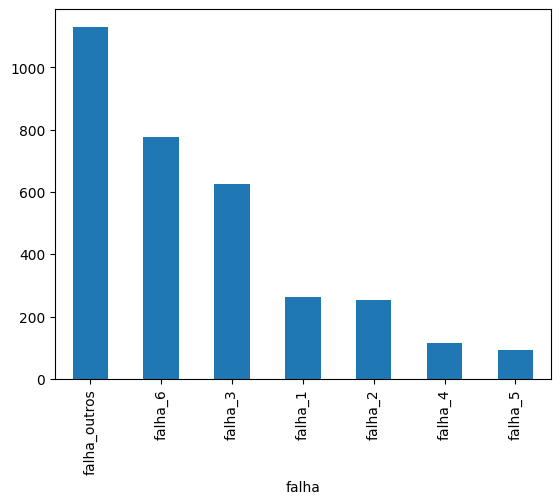

In [320]:
tabela_train["falha"].value_counts().plot(kind='bar')

tabela_train["falha"].value_counts(normalize=True) * 100

### Defeito aço A400

<Axes: title={'center': 'Defeito na placa de aço A400'}, xlabel='falha'>

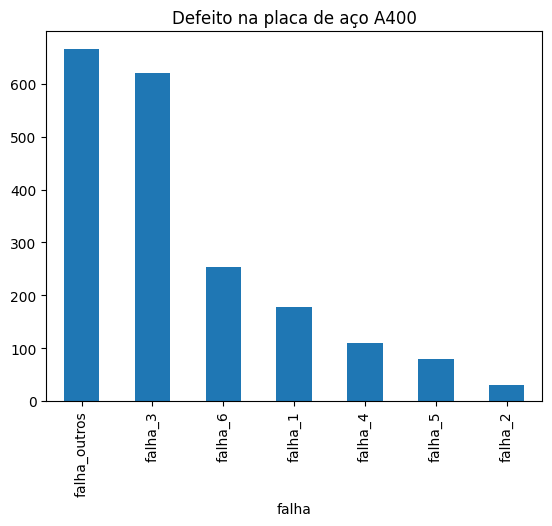

In [321]:
tabela_train[tabela_train["tipo_aço"] == "tipo_do_aço_A400"]["falha"].value_counts().plot(kind="bar", title="Defeito na placa de aço A400")

### Defeito aço A300

<Axes: title={'center': 'Defeito na placa de aço A300'}, xlabel='falha'>

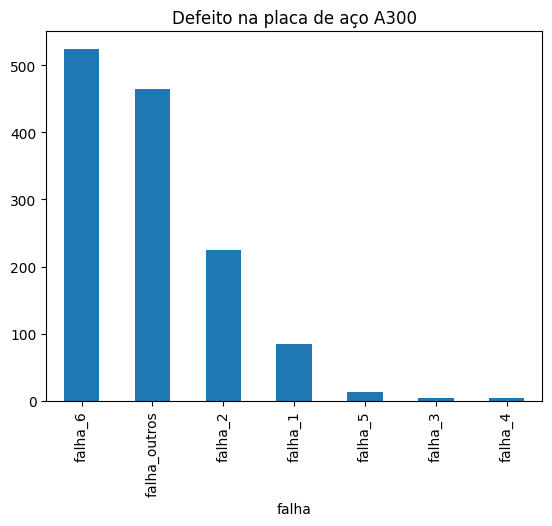

In [322]:
tabela_train[tabela_train["tipo_aço"] == "tipo_do_aço_A300"]["falha"].value_counts().plot(kind="bar", title="Defeito na placa de aço A300")

### Criar histogramas para cada falha de cada coluna da tabela

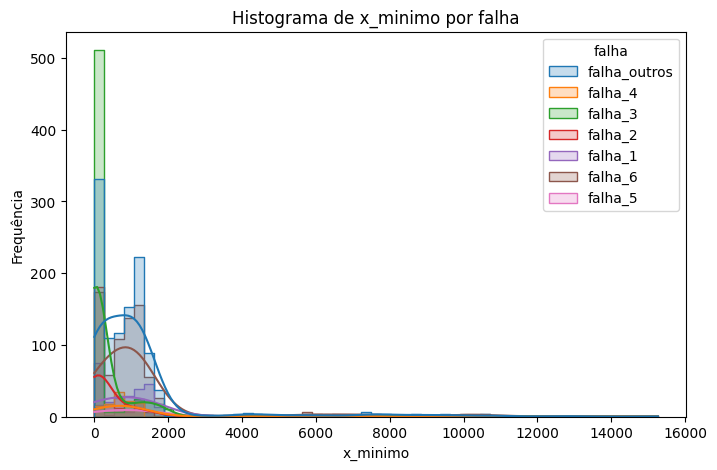

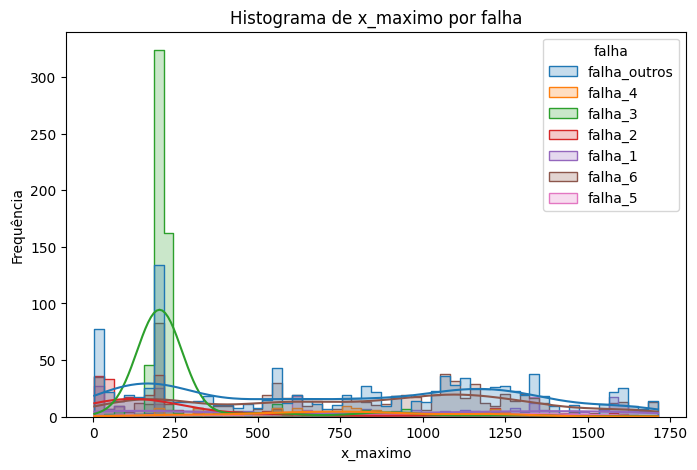

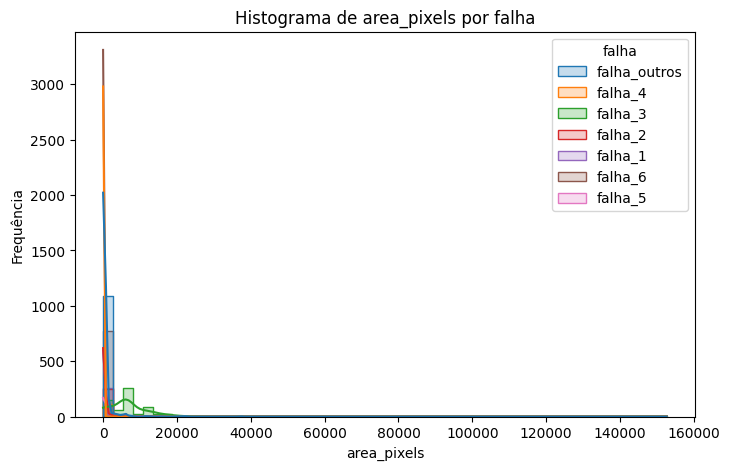

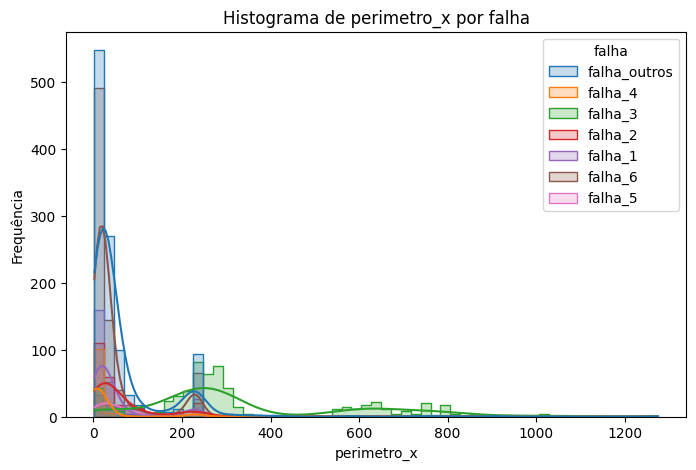

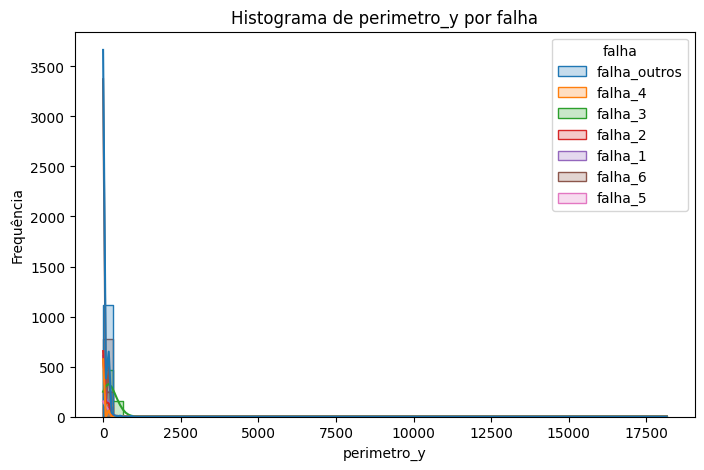

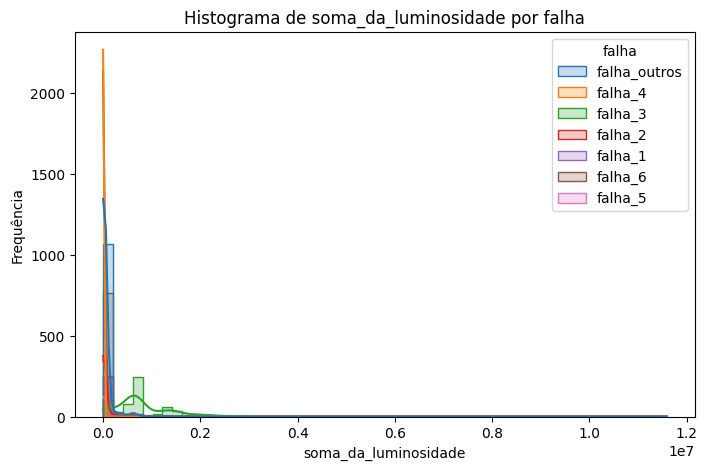

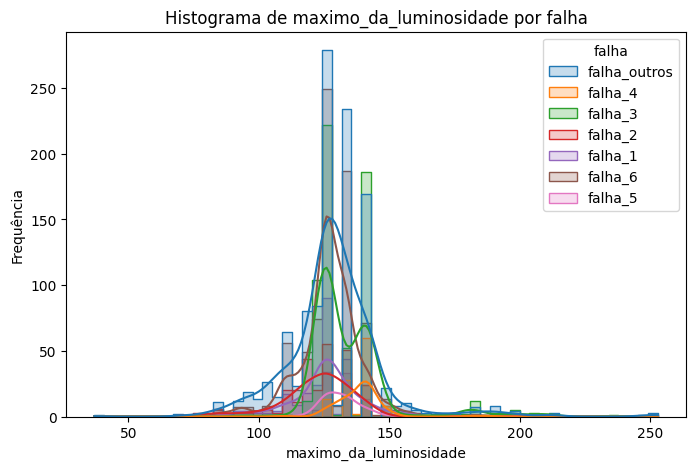

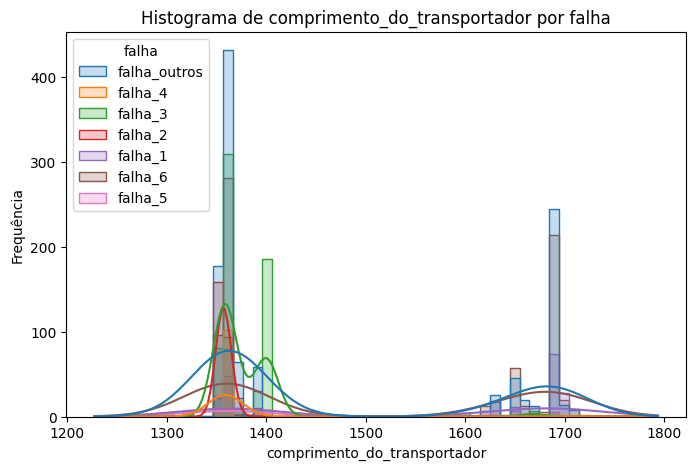

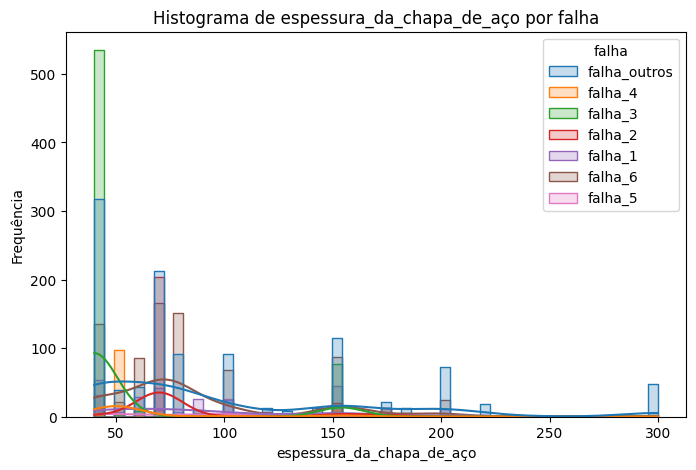

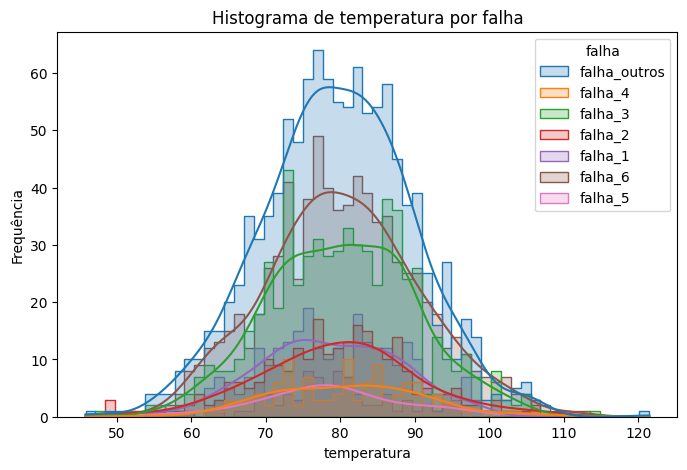

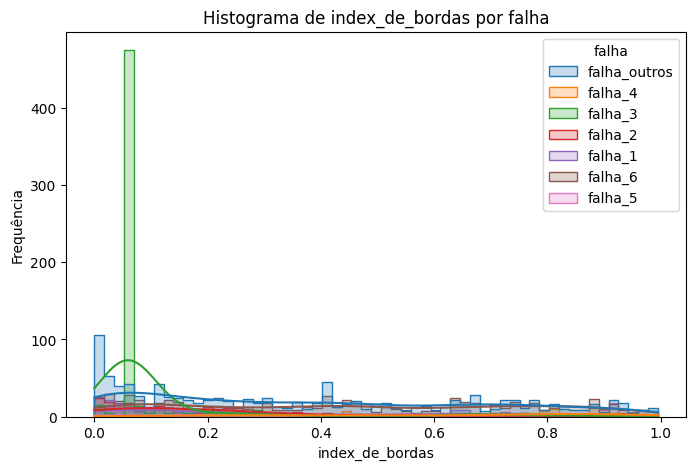

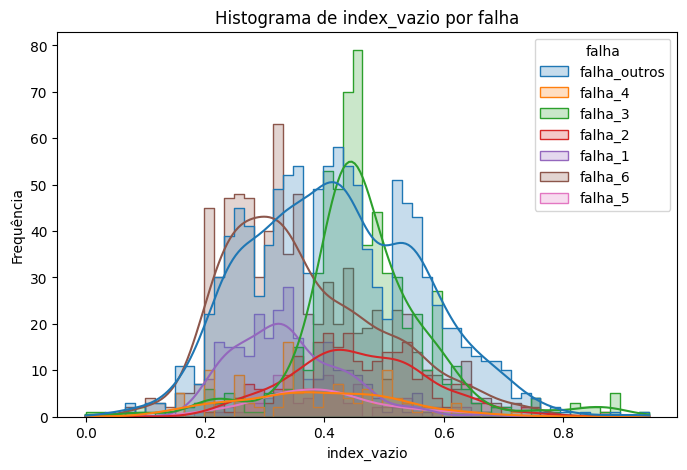

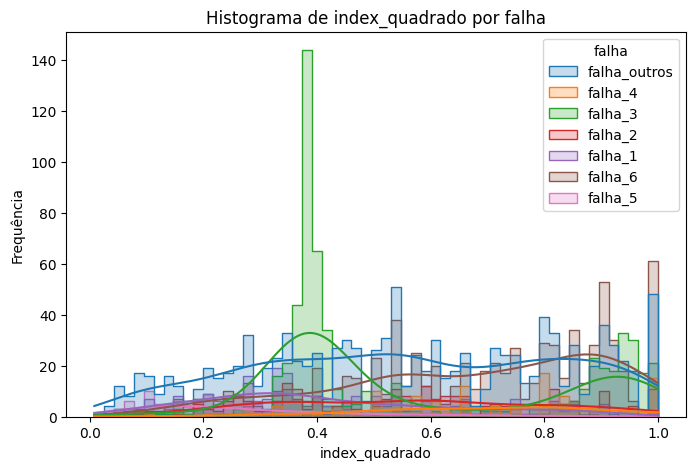

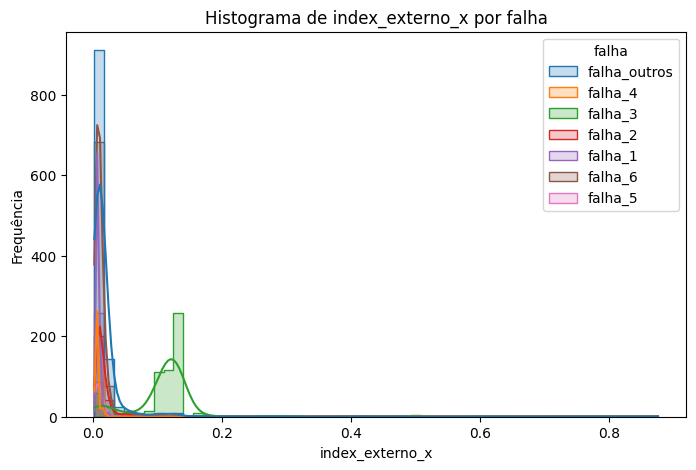

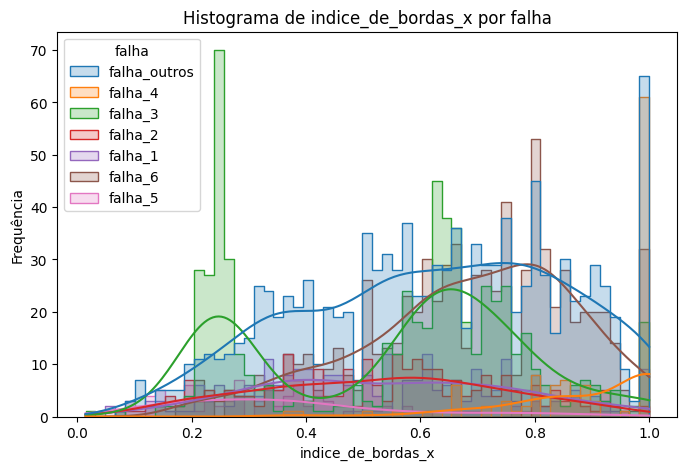

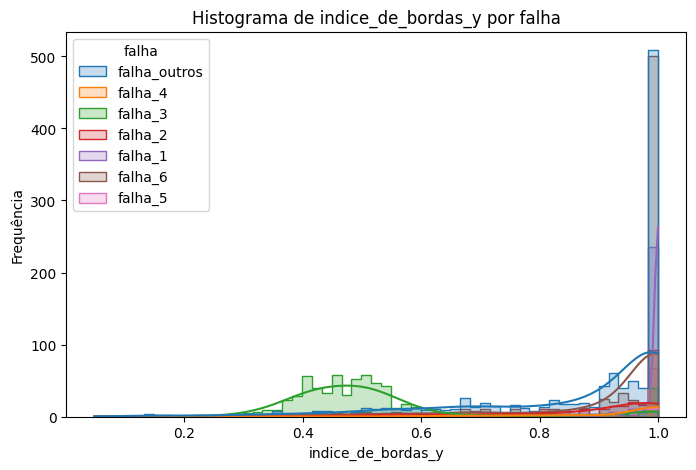

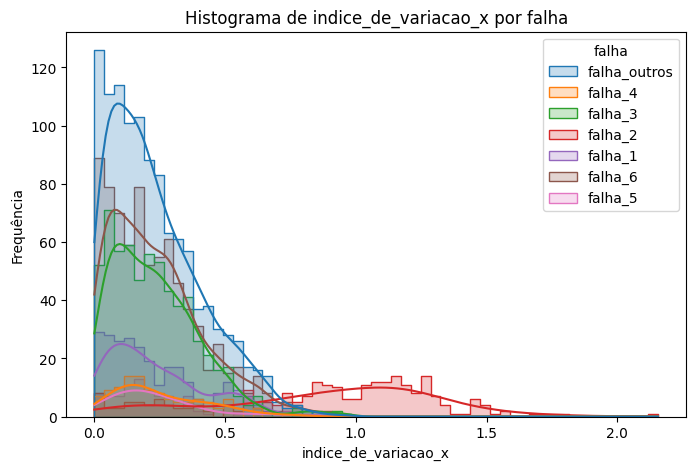

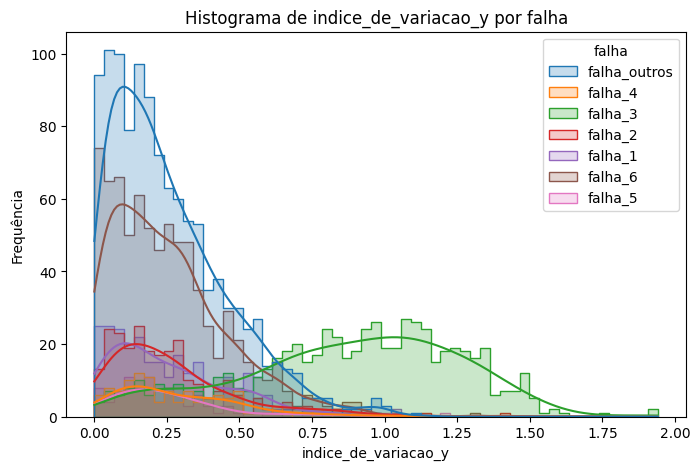

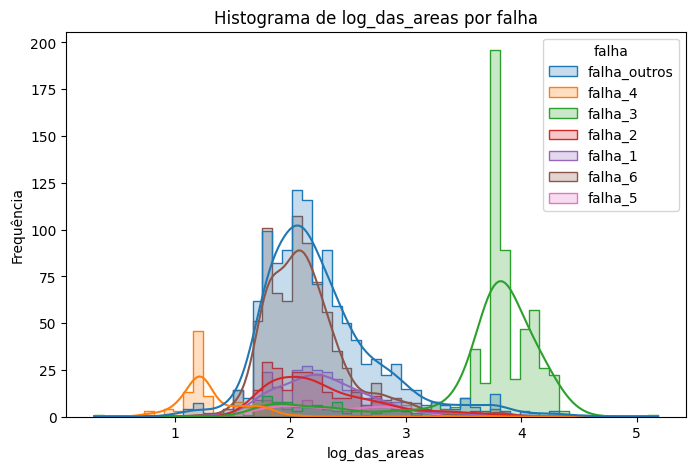

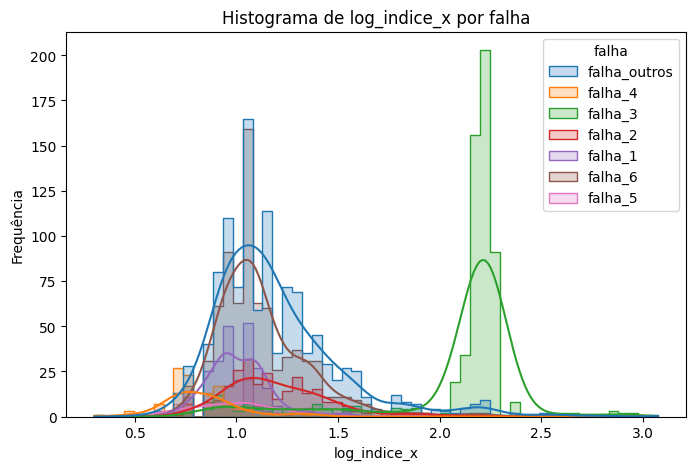

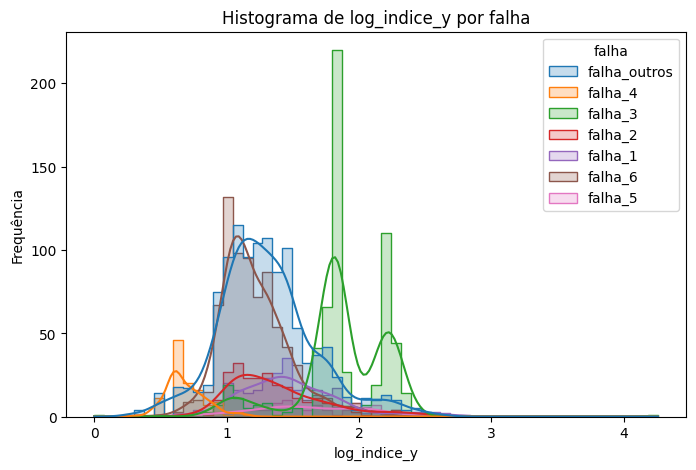

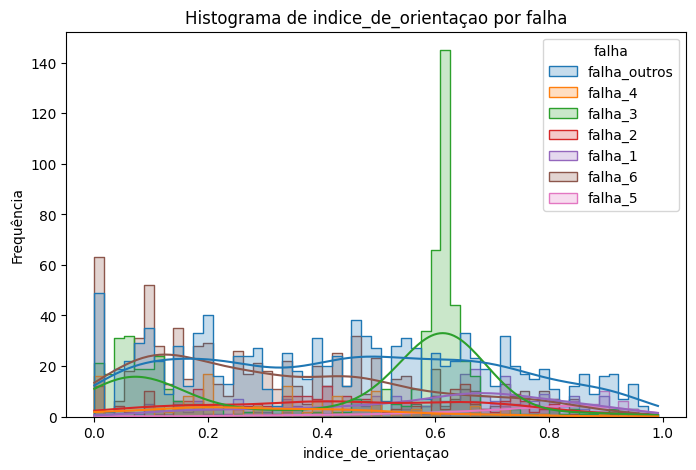

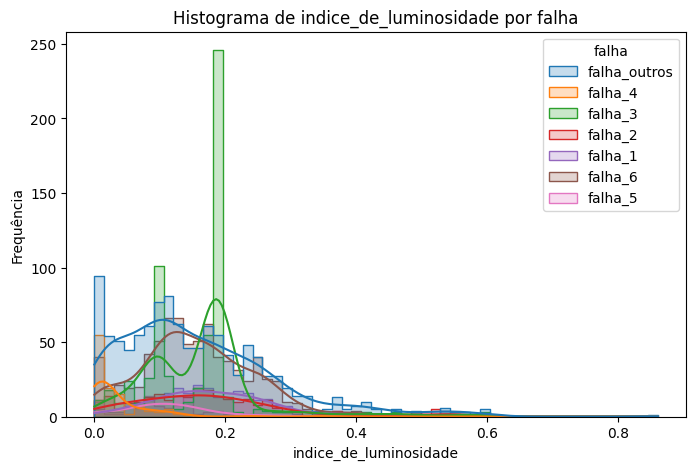

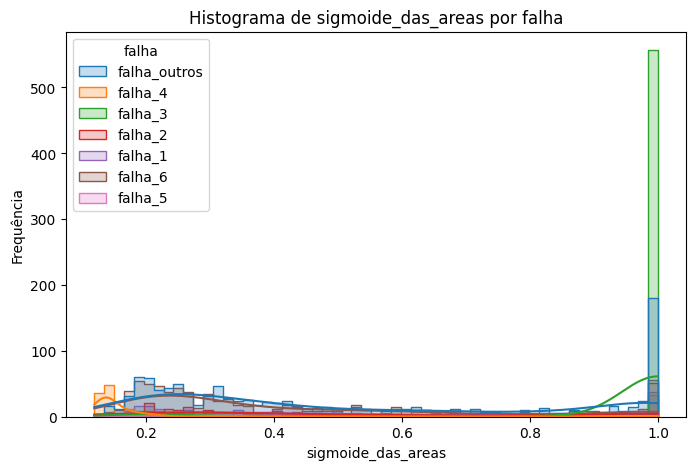

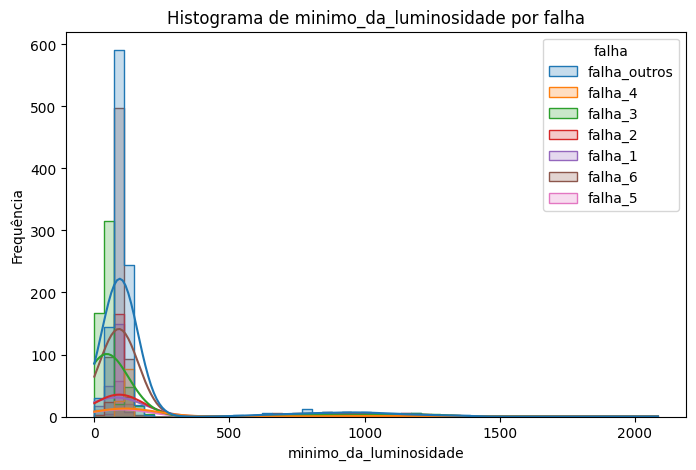

In [323]:
numerico = [coluna for coluna in tabela_train.columns if tabela_train[coluna].nunique() > 10]
catigoria = tabela_train.columns.difference(numerico).to_list()

for column in numerico :
    plot_histograms(tabela_train, column, "falha", bins)

### Criar boxplot para analisar os outliers

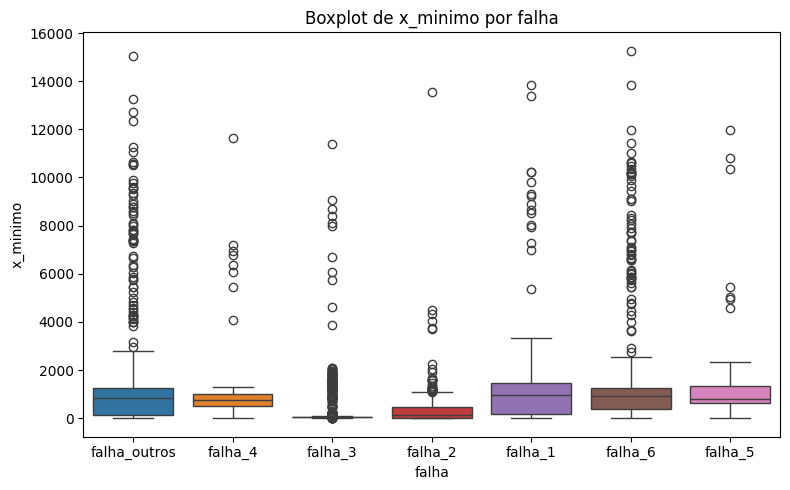

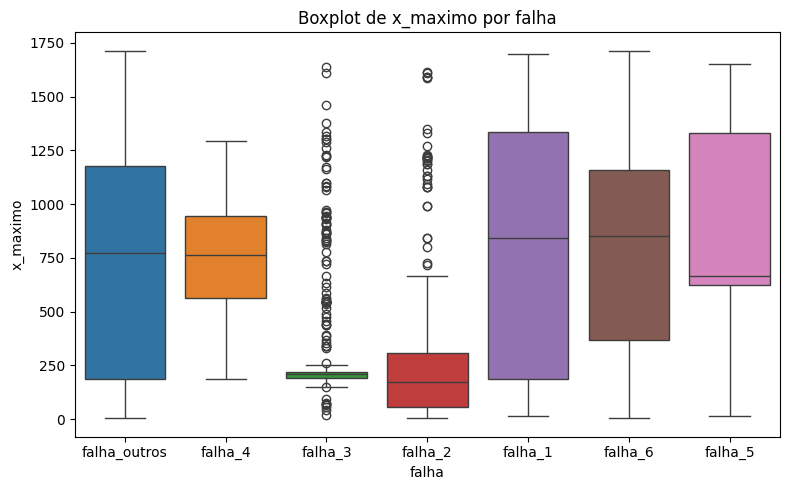

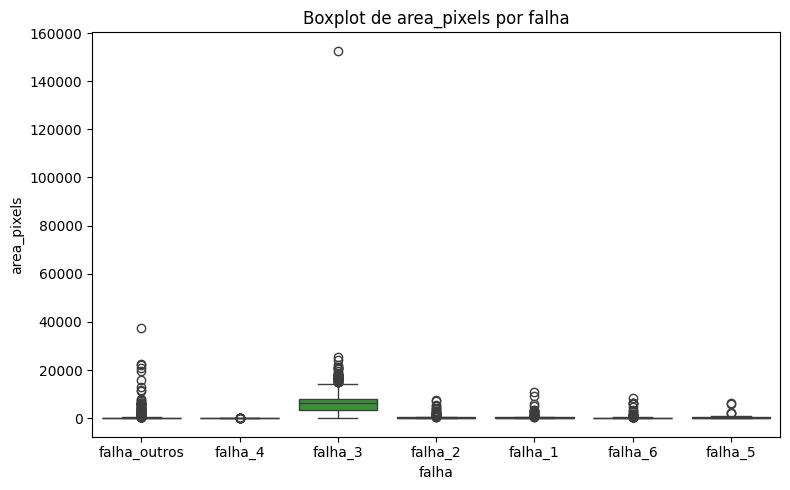

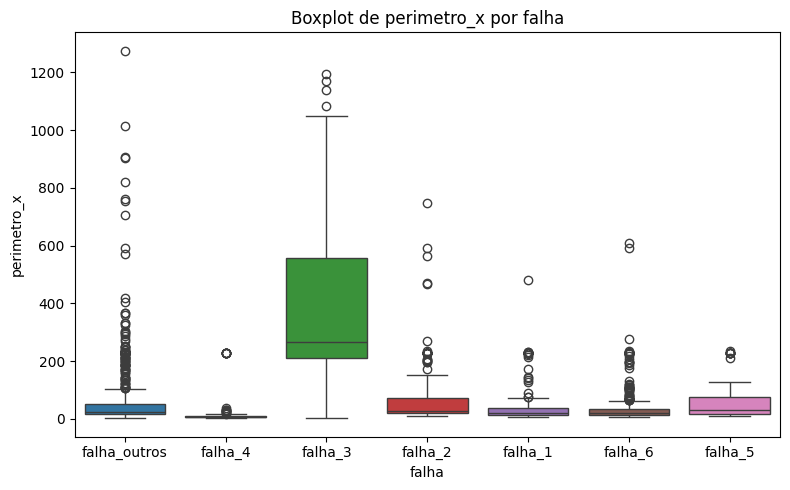

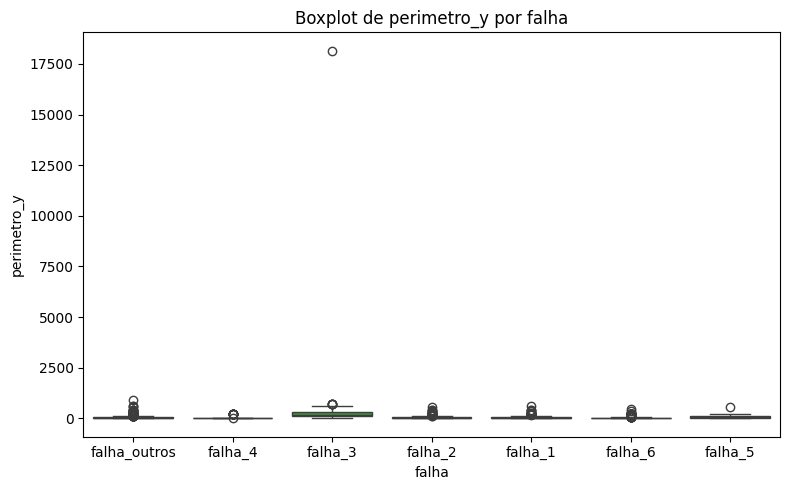

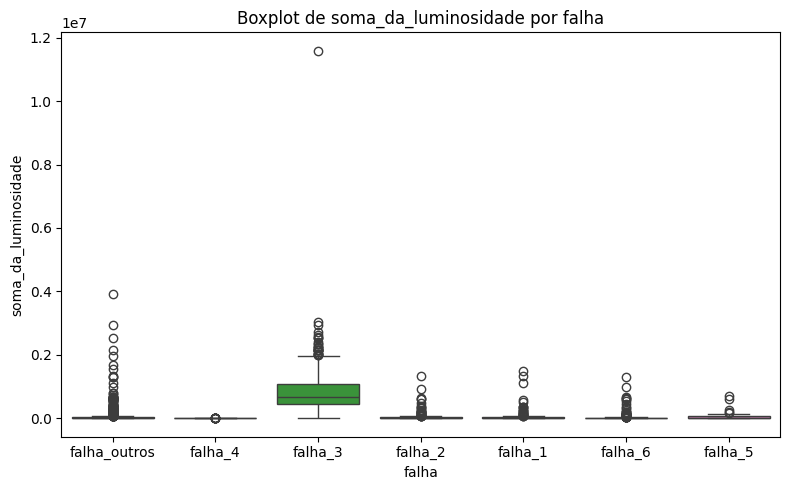

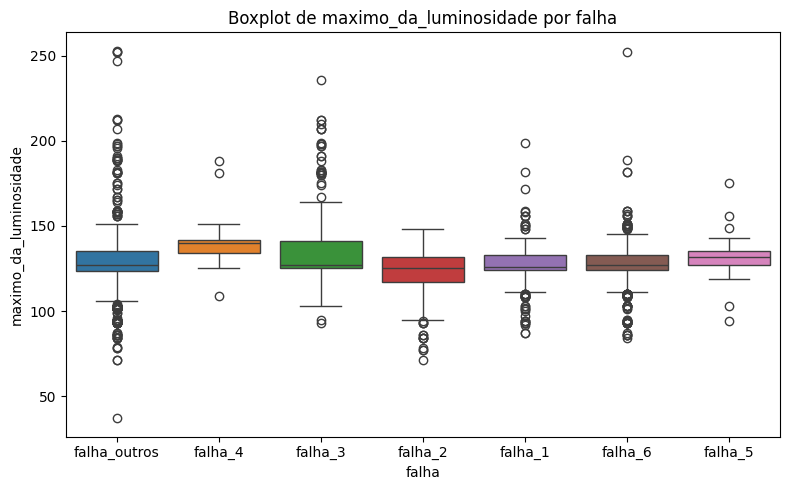

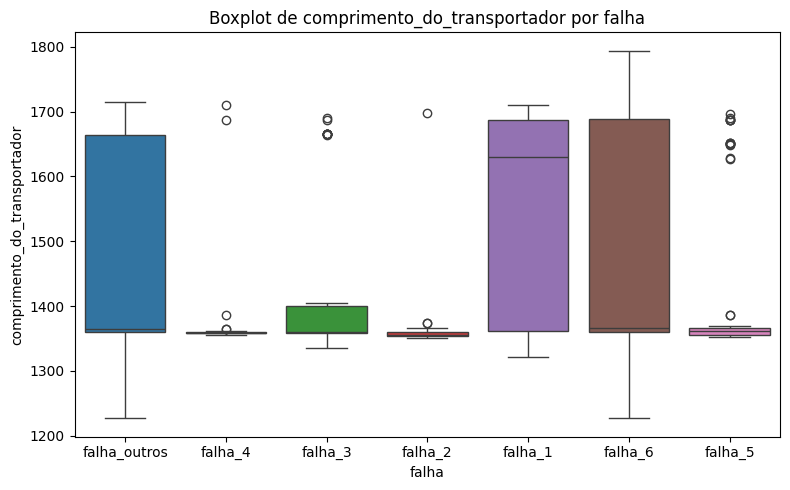

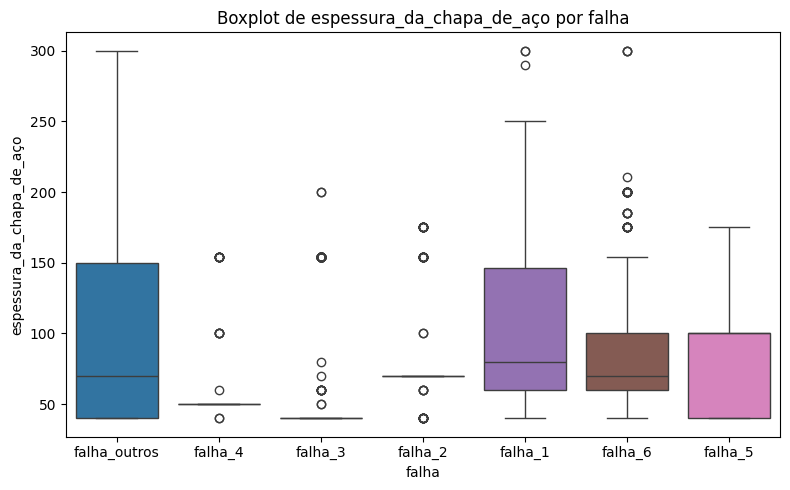

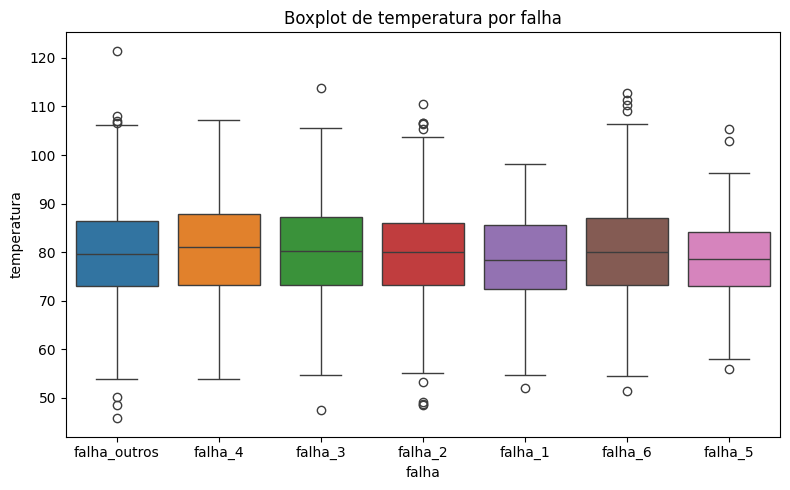

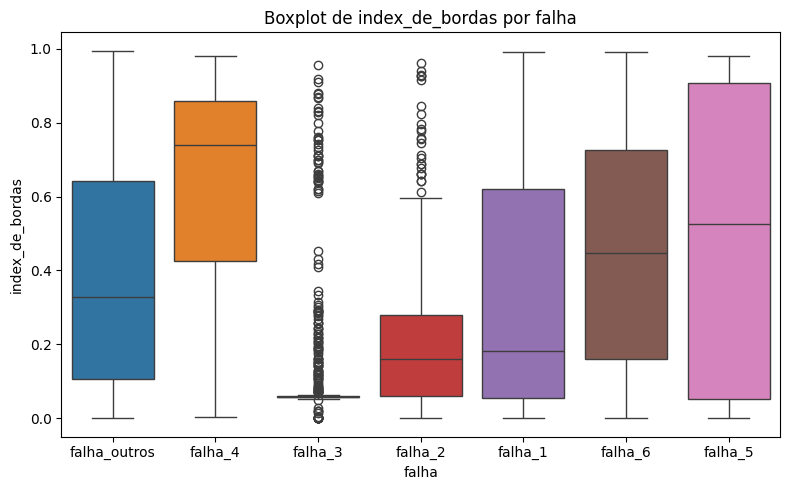

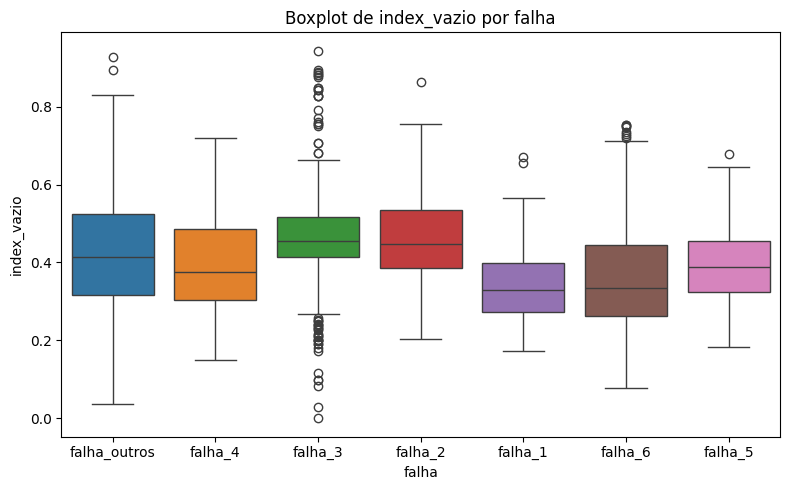

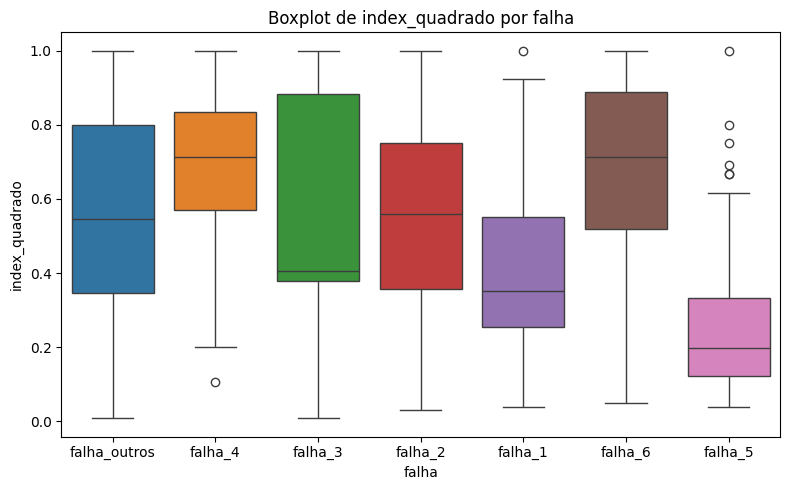

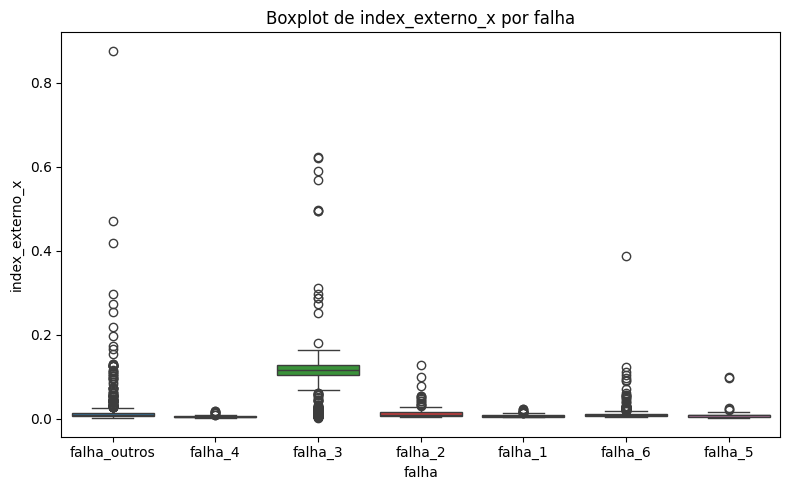

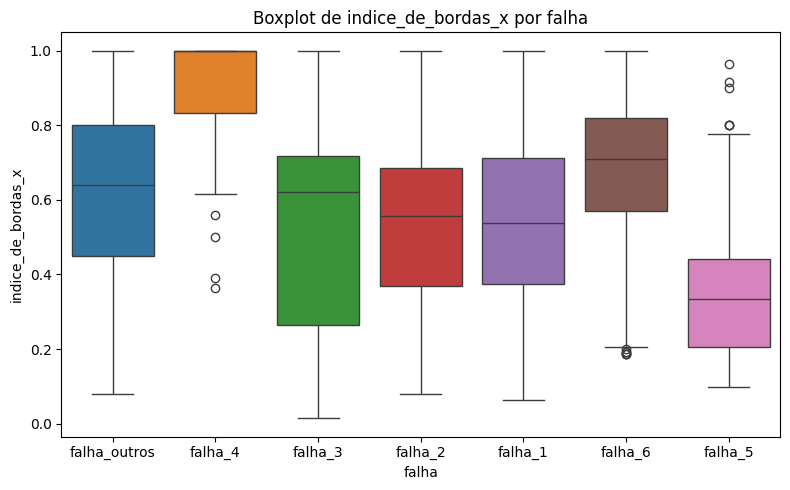

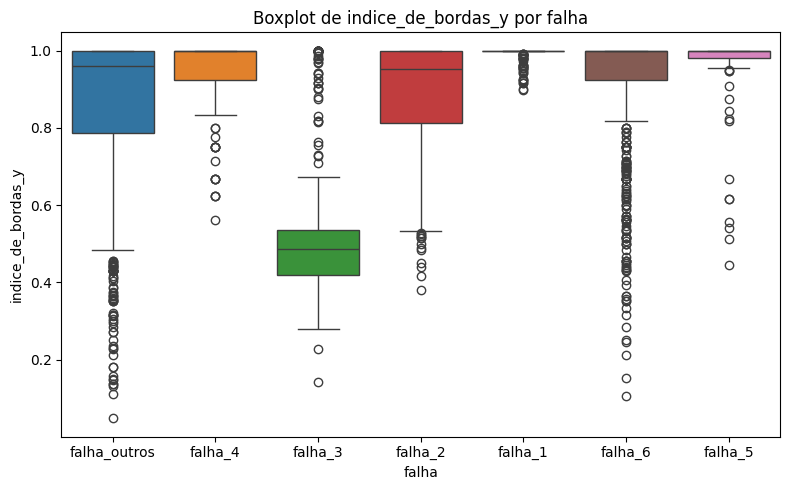

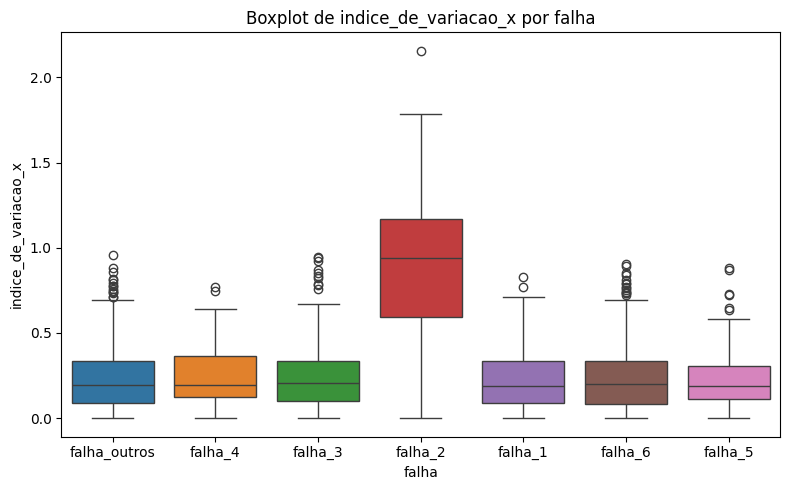

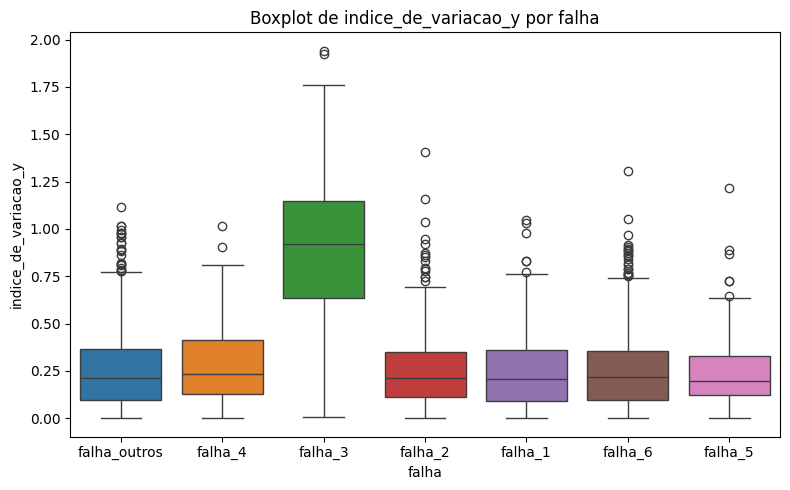

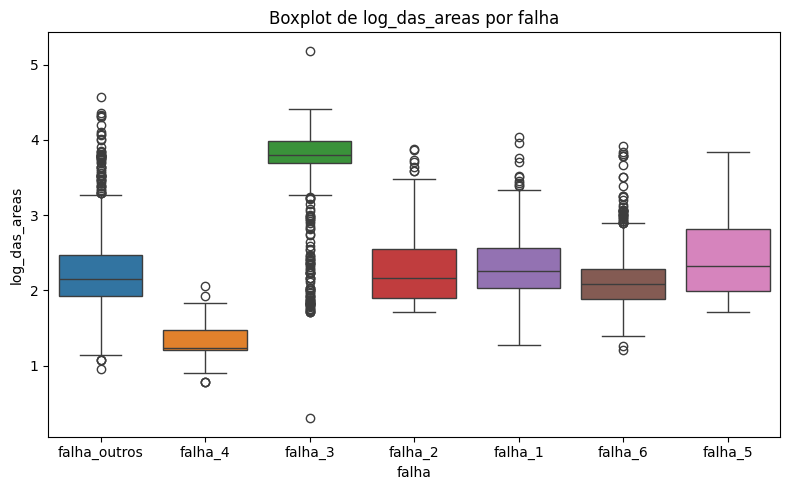

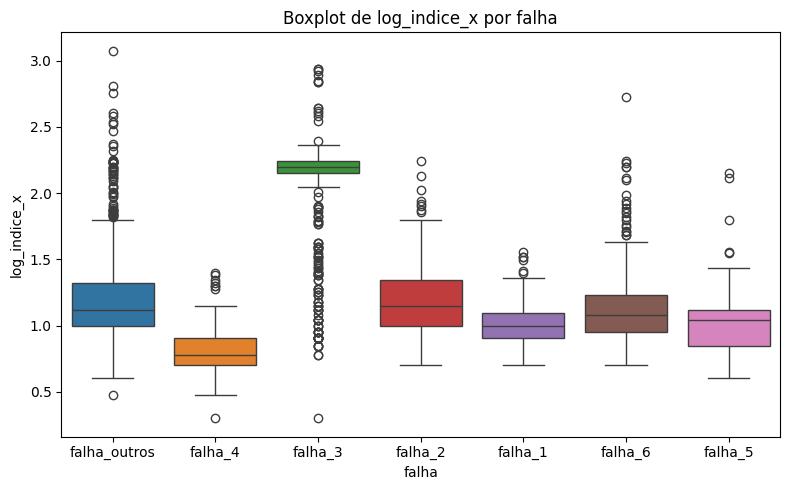

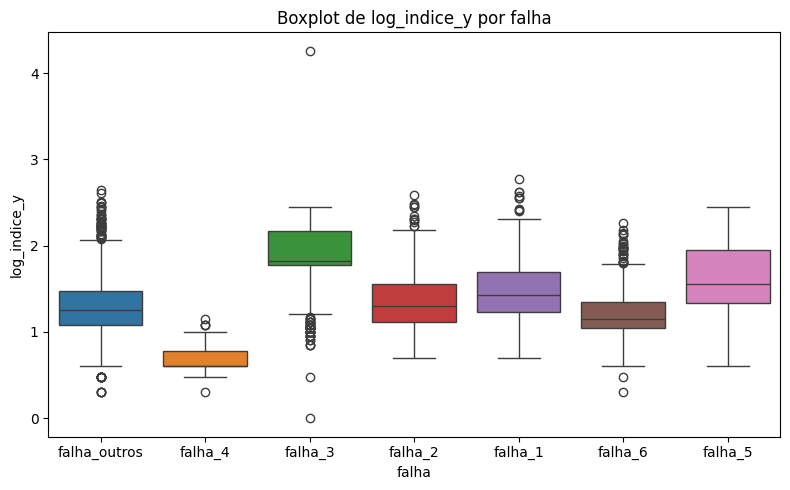

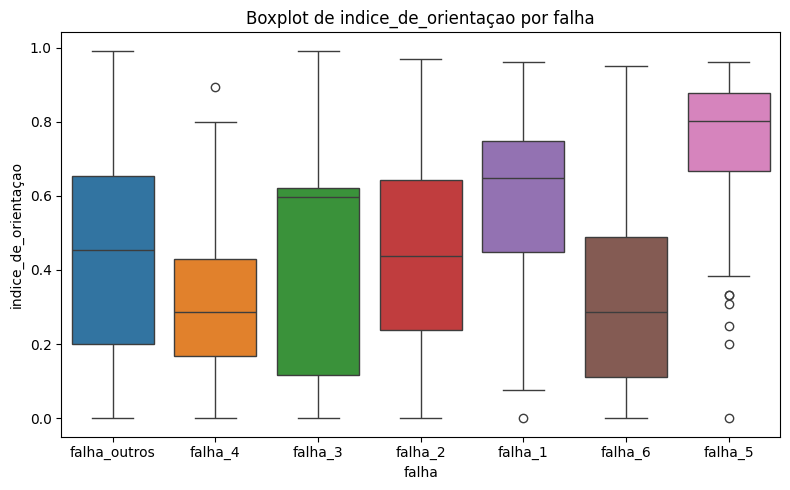

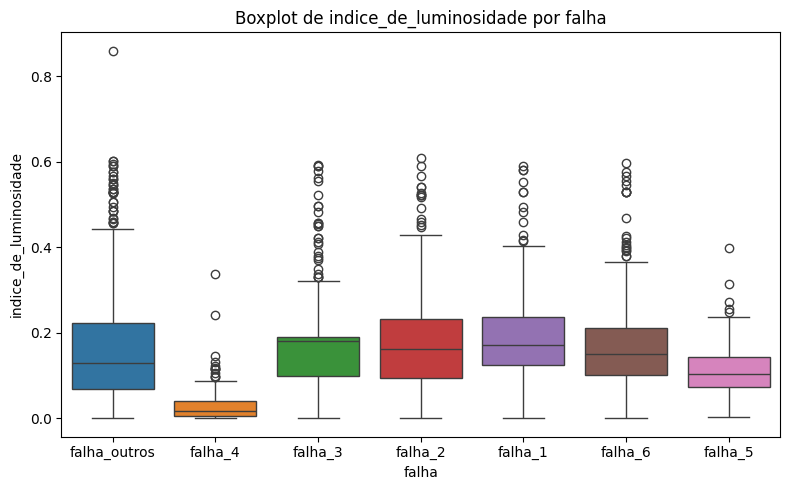

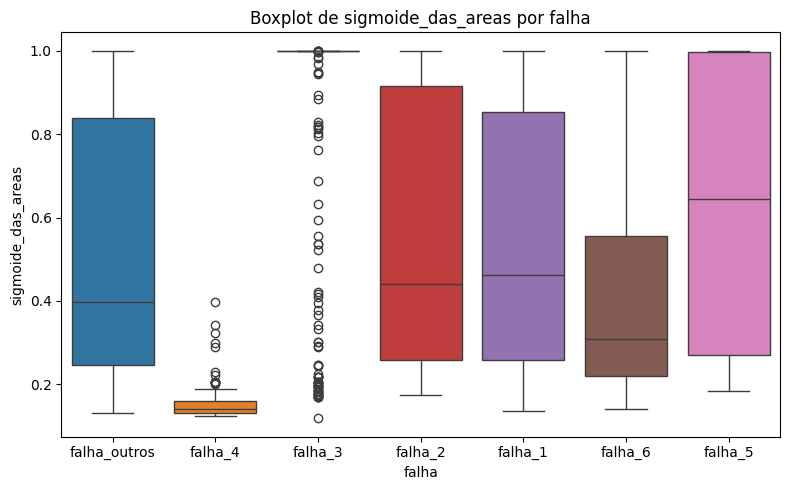

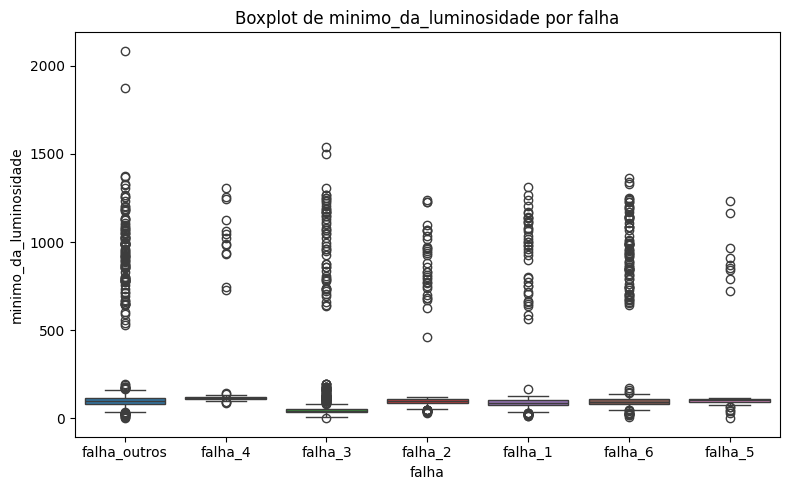

In [324]:
for column in numerico :
    plot_boxplots_category(tabela_train, column, "falha")

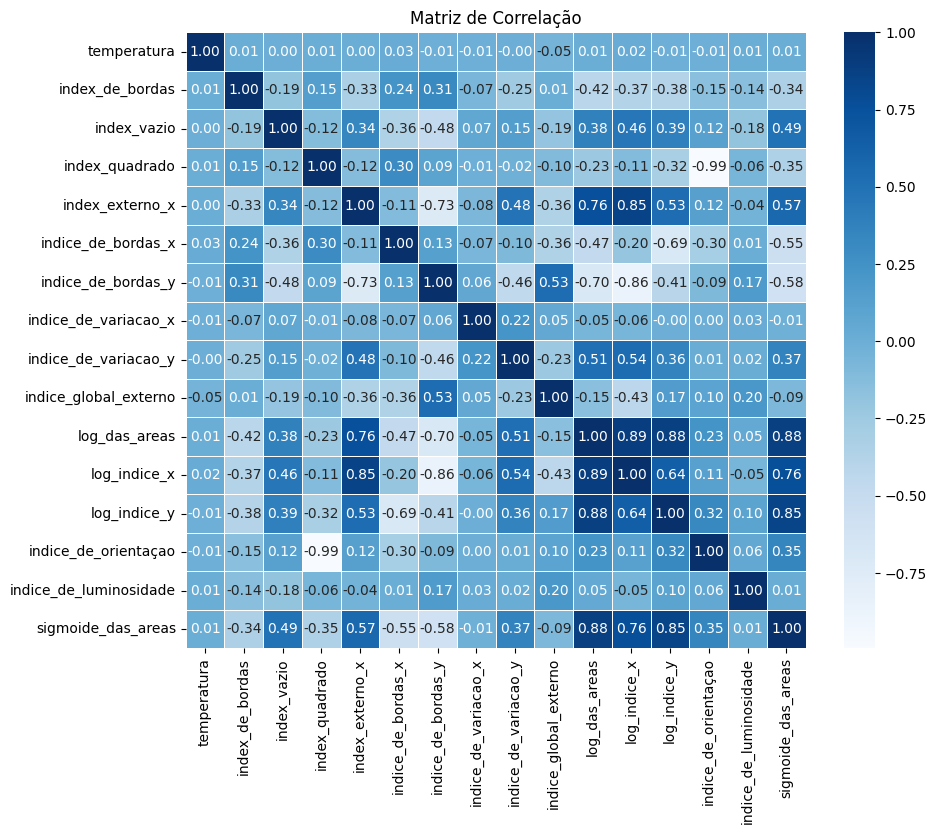

In [325]:
plot_correlation_matrix(tabela_train)

### Criar função para remover outliers mais extremos


In [326]:
def remover_outliers_pelo_tipo_falha(df, coluna_outlier, coluna_falha) :
    df_sem_outliers = pd.DataFrame()

    for falha, tabela in df.groupby(coluna_falha) :
        Q1 = tabela[coluna_outlier].quantile(0.25)
        Q3 = tabela[coluna_outlier].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 3 * IQR
        limite_superior = Q3 + 3 * IQR

        mediana = tabela[coluna_outlier].median()

        tabela[coluna_outlier] = np.where(
            (tabela[coluna_outlier] < limite_inferior) | (tabela[coluna_outlier] > limite_superior),
            mediana,
            tabela[coluna_outlier]
        )

        df_sem_outliers = pd.concat([df_sem_outliers, tabela])

    return df_sem_outliers


In [327]:
tabela_train

,x_minimo,x_maximo,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,espessura_da_chapa_de_aço,temperatura,...,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha,tipo_aço
0,154,169,75,27,17,9948,143,1364,40,80.799570,...,0.0,1.8751,1.1761,1.0792,0.2000,0.0362,0.3068,125,falha_outros,tipo_do_aço_A400
1,1121,186,206,9,194,2240,150,1362,50,79.790721,...,0.0,1.2305,0.8451,0.6990,0.2857,0.0294,0.1441,115,falha_4,tipo_do_aço_A400
2,41,216,6298,275,134,654634,126,1358,40,80.871970,...,0.0,3.7992,2.2430,1.7853,0.6514,0.1879,1.0000,42,falha_3,tipo_do_aço_A400
3,129,157,276,39,26,33858,135,1362,40,77.482247,...,0.0,2.4409,1.4472,1.2787,0.3214,0.0416,0.8223,115,falha_3,tipo_do_aço_A400
4,436,442,63,17,17,6374,116,1356,70,73.854550,...,1.0,1.7993,0.7782,1.2305,0.6471,0.2096,0.2083,90,falha_2,tipo_do_aço_A300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,779,802,755,177,17,764,127,1360,40,95.422194,...,0.0,2.8819,2.1139,1.0414,0.5454,0.1026,1.0000,103,falha_6,tipo_do_aço_A400
3386,41,188,3437,248,116,354240,143,1360,40,89.777382,...,0.0,3.5362,2.1644,1.6721,0.5163,0.1749,1.0000,42,falha_outros,tipo_do_aço_A400
3387,823,834,135,20,194,14169,132,1650,80,76.502729,...,1.0,2.1303,1.2305,1.3010,0.5000,0.1264,0.3977,97,falha_6,tipo_do_aço_A300
3388,9505,186,206,29,26,17836,134,1362,154,72.926750,...,0.0,2.3636,1.4314,1.2787,0.1923,0.0238,0.8355,116,falha_outros,tipo_do_aço_A400


In [328]:
tabela_train.shape

(3258, 28)

In [329]:
tabela_train.shape

(3258, 28)

In [330]:
for column in numerico :
    tabela_train = remover_outliers_pelo_tipo_falha(
        tabela_train,
        column,
        "falha"
    )

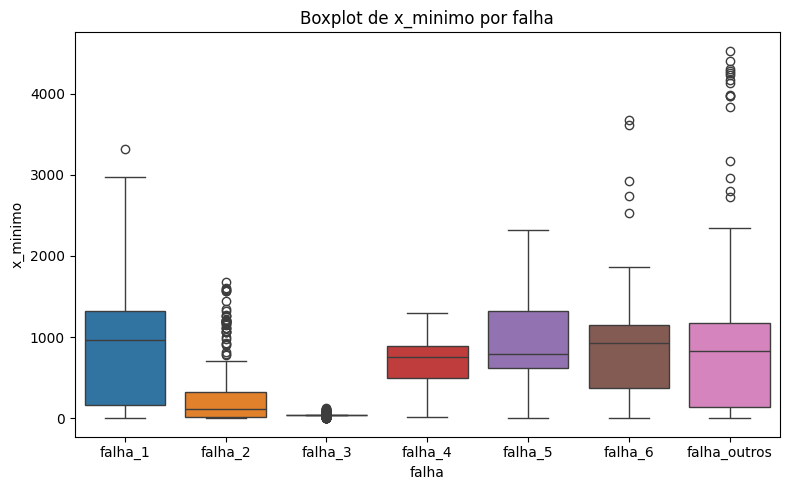

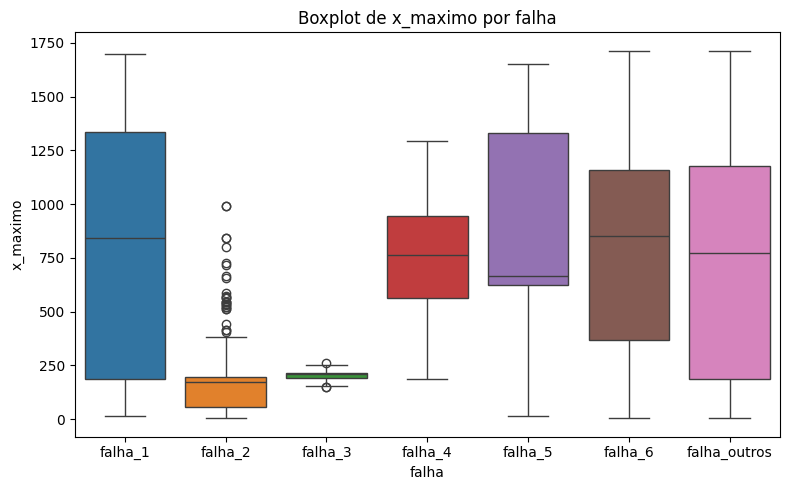

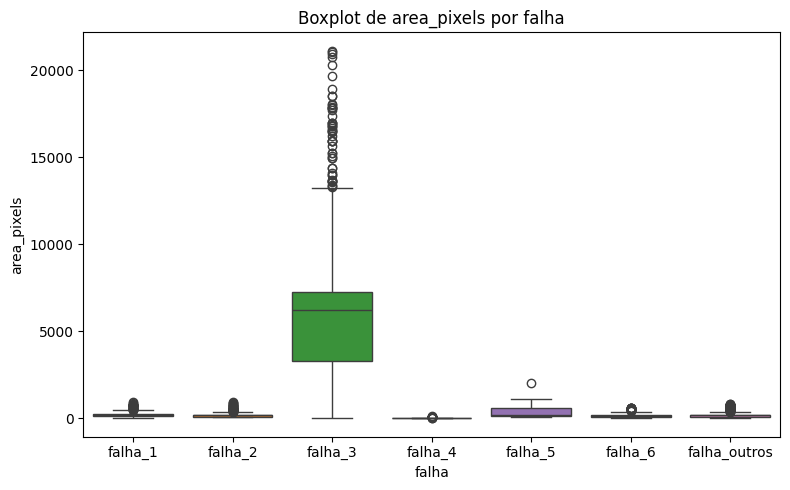

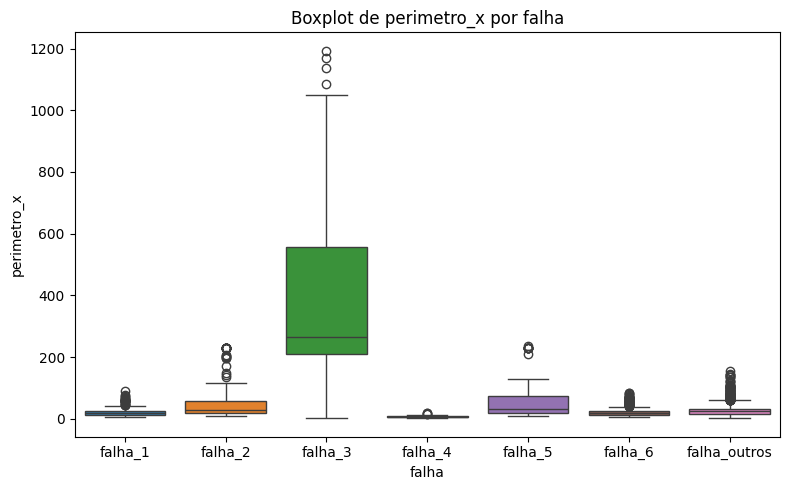

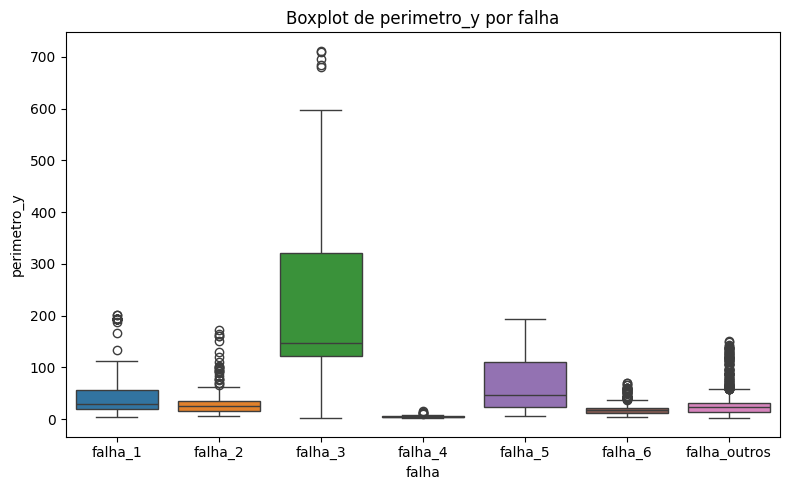

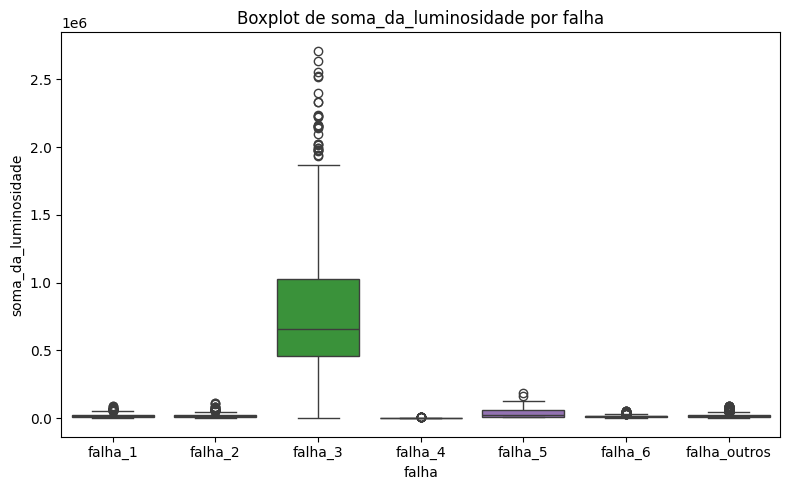

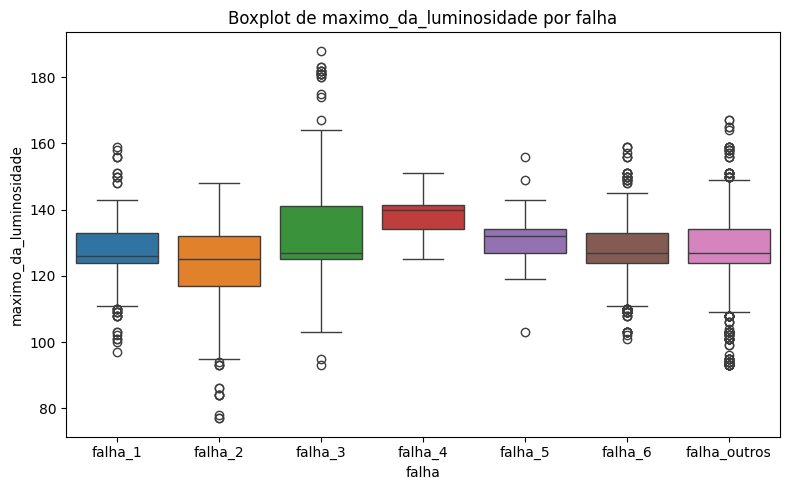

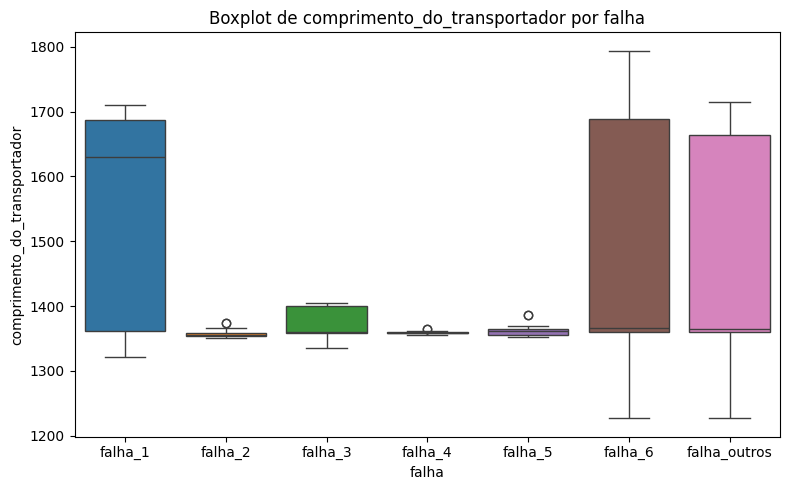

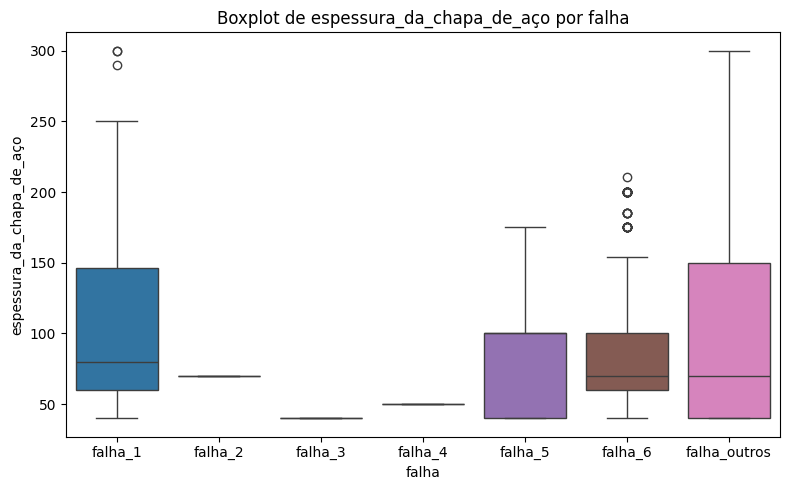

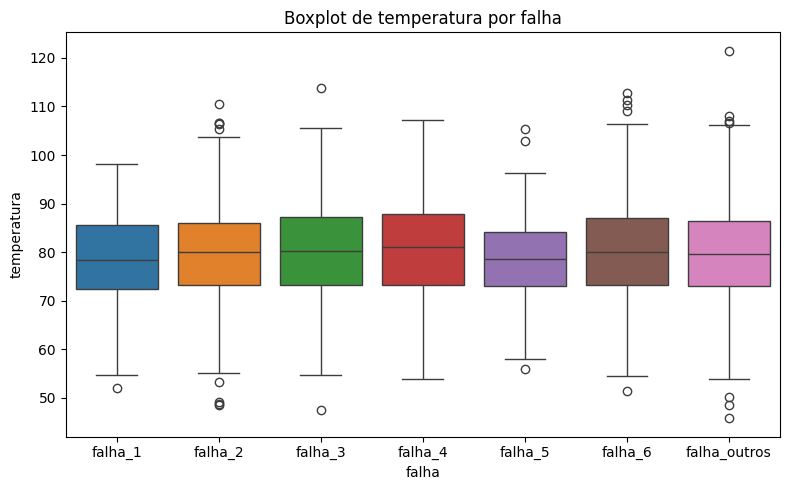

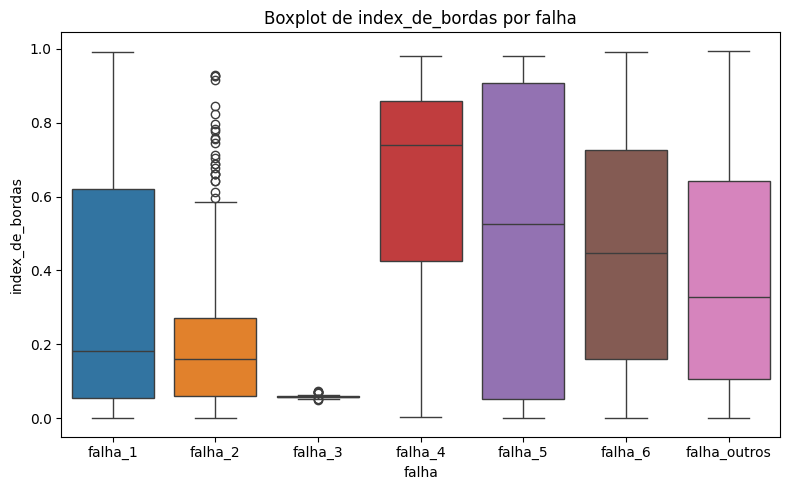

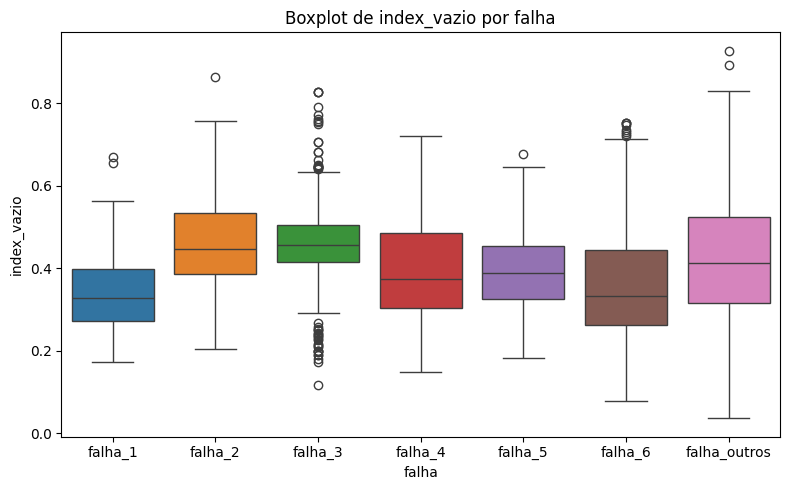

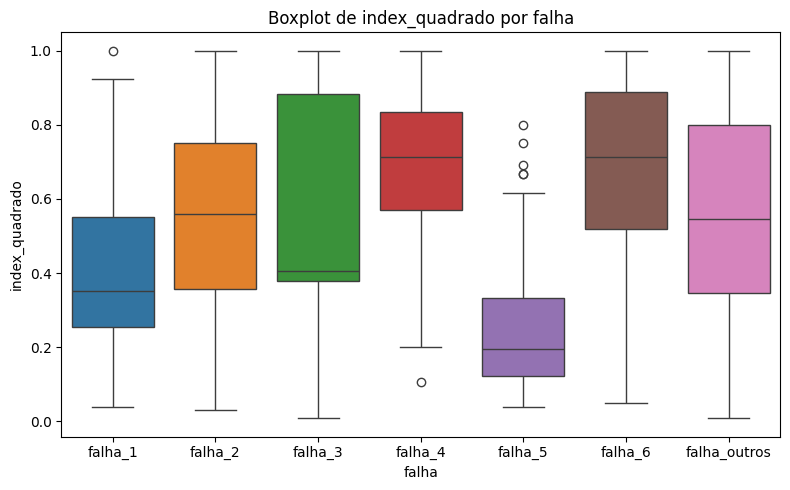

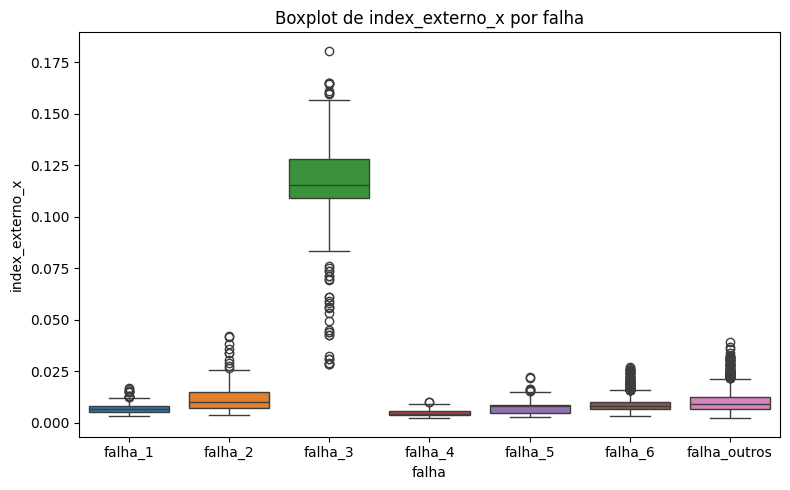

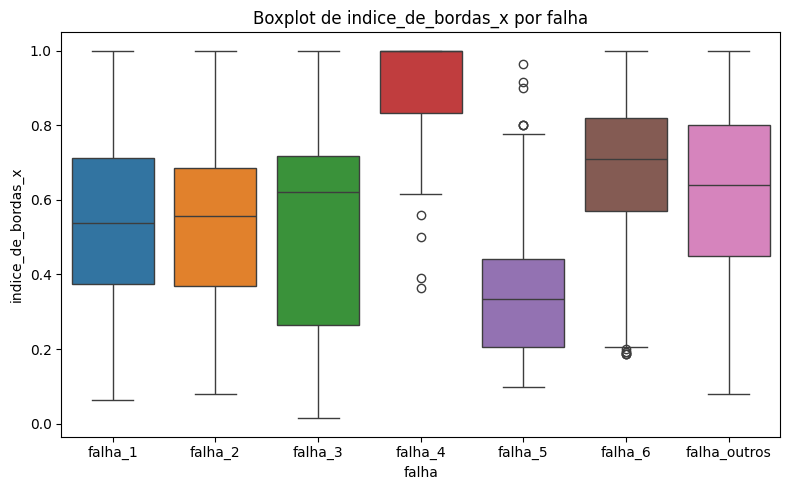

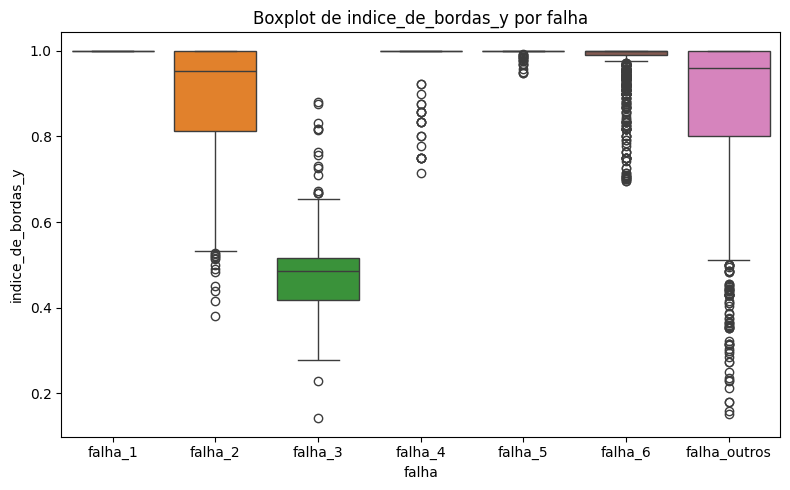

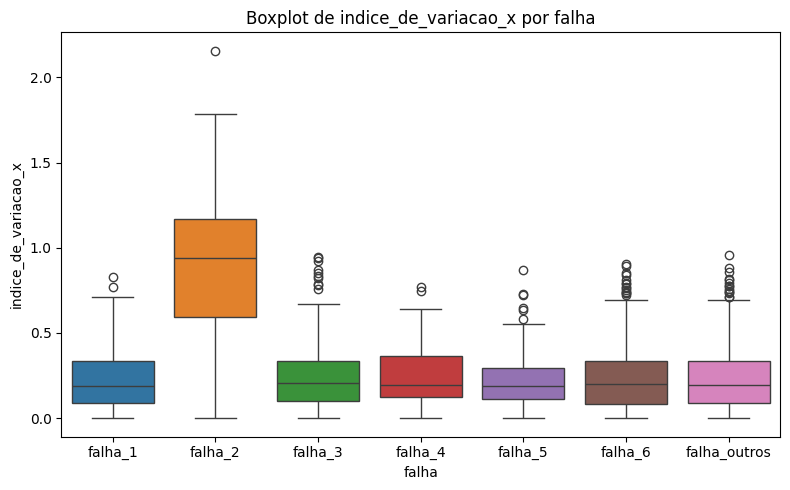

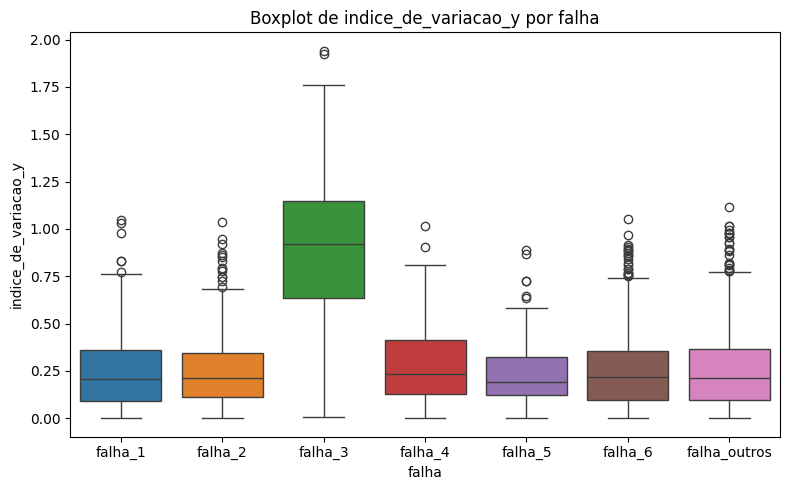

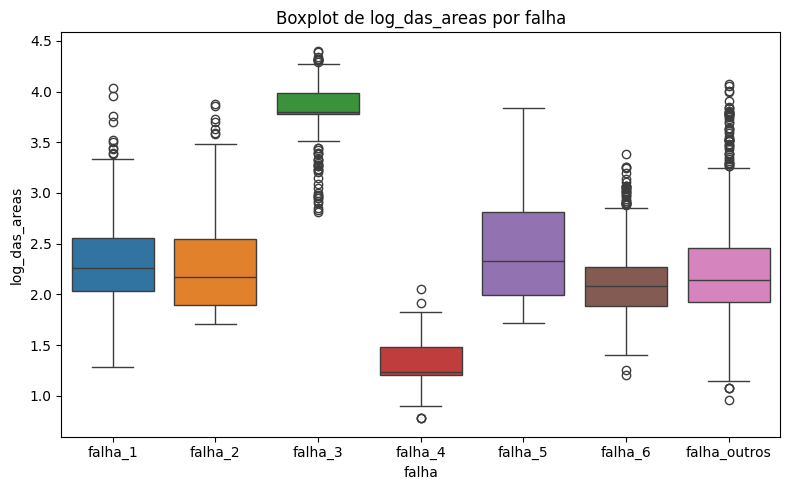

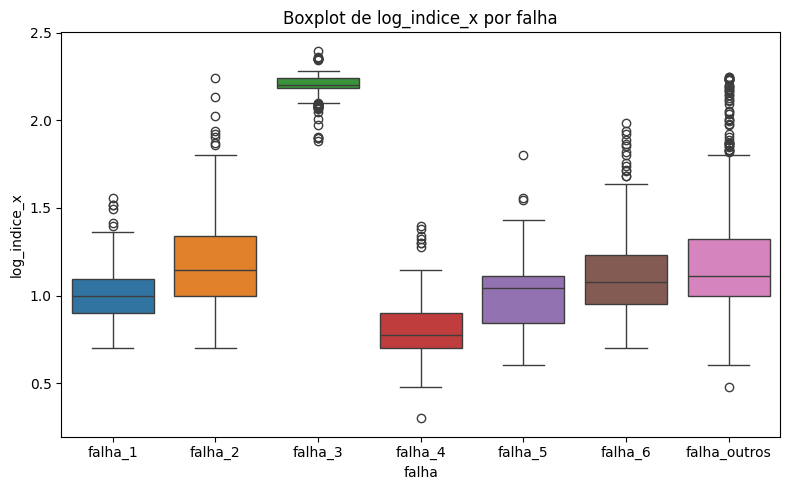

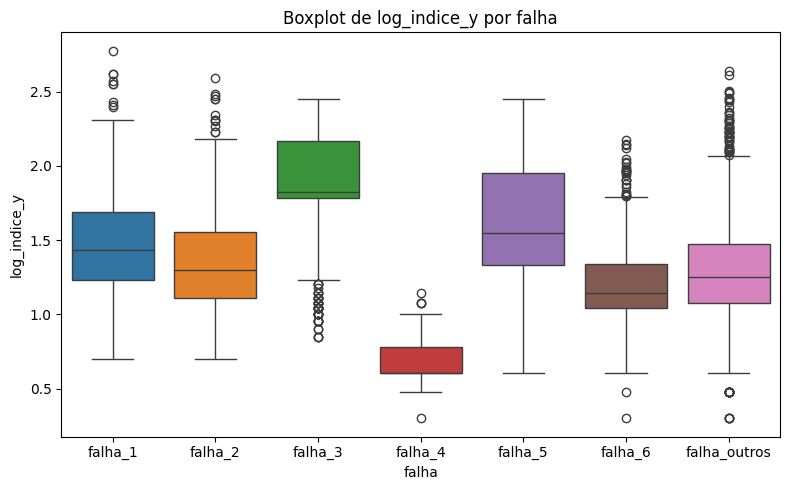

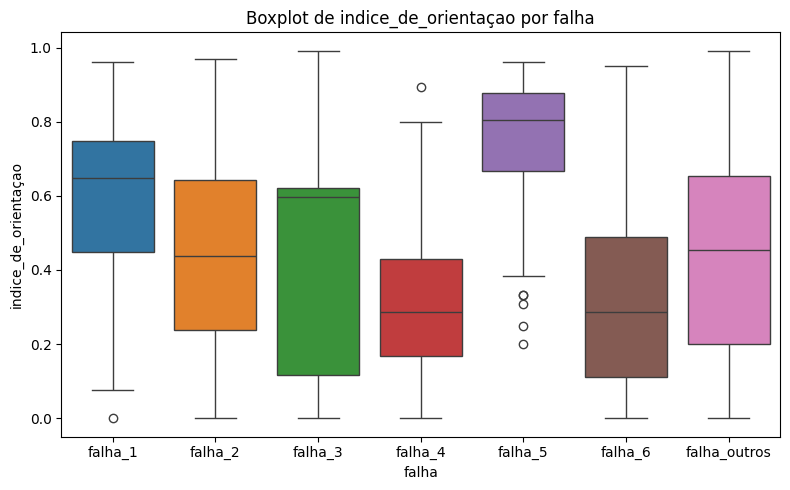

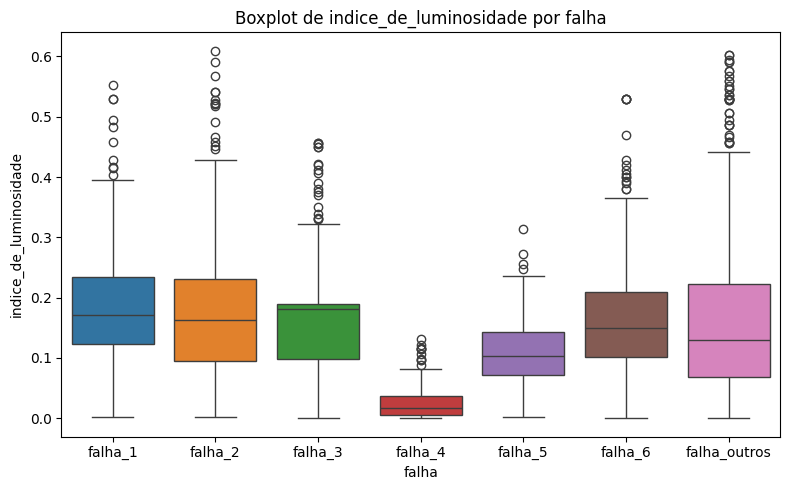

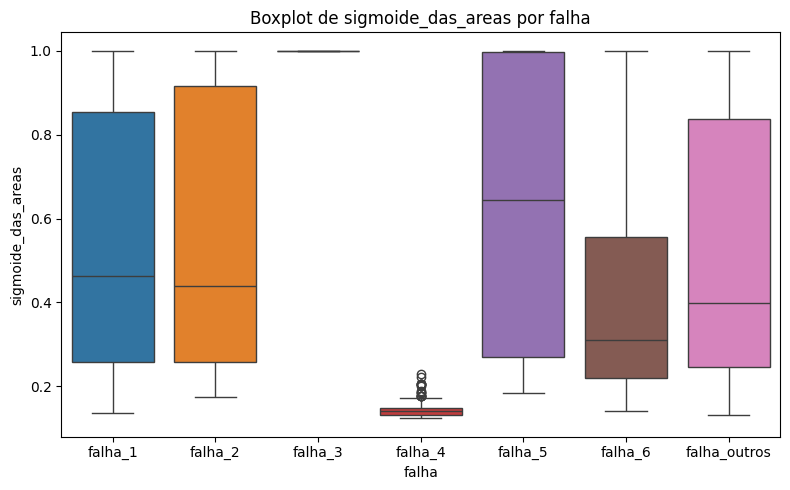

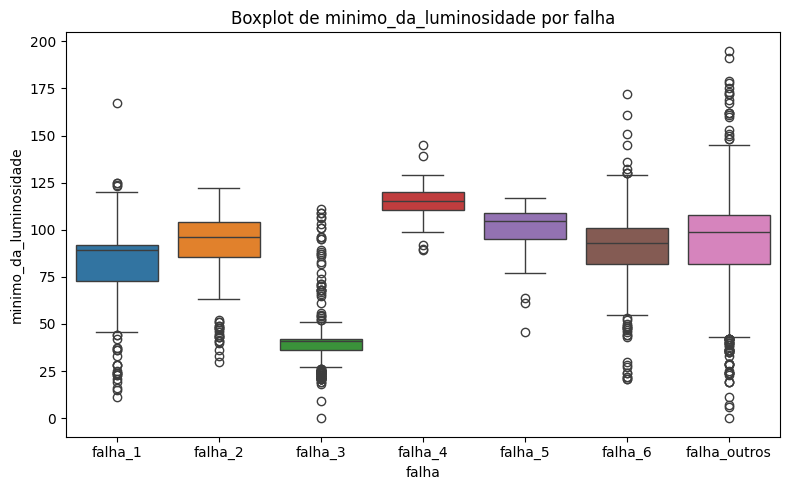

In [331]:
for column in numerico :
    plot_boxplots_category(tabela_train, column, "falha")

In [332]:
#sns.pairplot(tabela_train, hue="falha")

## XGBoost

### Criar um modelo com o XGBoots
Durante a análise foi detectado excesso de outliers, se remover ou alterar todos para a média ou mediana pode comprometer o modelo. Foi feito uma pesquisa e o XGBoost é um modelo que lida bem com outliers.

In [333]:
X = tabela_train.drop(columns=["falha"]).copy()
y = tabela_train["falha"].copy()

In [334]:
customizar = {
    "falha" : ["falha 1", "falha 2", "falha 3", "falha 4", "falha 5", "falha 6", "outras falhas"],
    "tipo_aço" :["tipo_do_aço_A300", "tipo_do_aço_A400"]
}

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [336]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [337]:
y_test = le.transform(y_test)

In [338]:
y_train

array([3, 5, 2, ..., 6, 1, 6], shape=(2606,))

In [339]:
y_test

array([2, 6, 6, 5, 4, 6, 2, 2, 4, 5, 6, 5, 5, 5, 6, 5, 6, 6, 1, 5, 5, 2,
       2, 2, 6, 6, 1, 4, 5, 2, 1, 6, 6, 2, 6, 2, 6, 5, 5, 5, 2, 6, 0, 5,
       5, 6, 6, 5, 5, 3, 6, 6, 2, 2, 5, 2, 6, 2, 6, 2, 6, 6, 6, 3, 4, 5,
       2, 2, 6, 5, 6, 6, 0, 5, 5, 2, 6, 5, 2, 1, 5, 6, 2, 2, 0, 6, 6, 2,
       5, 0, 6, 6, 2, 5, 5, 2, 1, 2, 6, 2, 6, 6, 1, 6, 6, 6, 2, 5, 5, 3,
       2, 6, 3, 3, 5, 6, 1, 1, 5, 6, 0, 5, 6, 6, 5, 2, 0, 5, 1, 2, 6, 5,
       0, 6, 3, 2, 0, 6, 1, 5, 1, 6, 0, 6, 6, 1, 6, 5, 6, 3, 6, 2, 2, 6,
       1, 5, 4, 1, 2, 1, 5, 5, 1, 6, 3, 6, 2, 6, 6, 4, 6, 6, 6, 6, 4, 2,
       5, 6, 5, 0, 5, 0, 1, 5, 2, 6, 4, 2, 6, 5, 2, 2, 6, 5, 6, 6, 0, 5,
       3, 6, 5, 6, 6, 3, 1, 6, 1, 6, 6, 6, 0, 6, 0, 5, 6, 6, 0, 0, 1, 0,
       2, 6, 2, 4, 2, 2, 6, 5, 5, 6, 6, 2, 0, 6, 2, 1, 6, 5, 5, 6, 0, 0,
       3, 6, 6, 3, 0, 2, 1, 1, 6, 5, 5, 5, 2, 1, 0, 5, 6, 2, 2, 5, 5, 2,
       2, 6, 5, 2, 6, 5, 6, 3, 3, 5, 6, 2, 5, 6, 5, 2, 6, 0, 6, 5, 1, 6,
       5, 5, 6, 6, 6, 5, 5, 6, 2, 6, 0, 5, 2, 3, 5,

In [340]:
preprocessor = ColumnTransformer(
    transformers= [
        ("falha", StandardScaler(), numerico)
    ]
)


In [341]:
xgb_clf = Pipeline(steps=[
    ("processando", preprocessor),
    ("classificar", xgb.XGBClassifier(random_state=42, base_score=0.5))
])

In [342]:
%%time
xgb_clf.fit(X_train, y_train)

CPU times: total: 21.4 s
Wall time: 5.43 s


Pipeline(steps=[('processando',
                 ColumnTransformer(transformers=[('falha', StandardScaler(),
                                                  ['x_minimo', 'x_maximo',
                                                   'area_pixels', 'perimetro_x',
                                                   'perimetro_y',
                                                   'soma_da_luminosidade',
                                                   'maximo_da_luminosidade',
                                                   'comprimento_do_transportador',
                                                   'espessura_da_chapa_de_aço',
                                                   'temperatura',
                                                   'index_de_bordas',
                                                   'index_vazio',
                                                   'index_quadrado',
                                                   'index_externo_x',
                                                   'indice_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [343]:
y_pred = xgb_clf.predict(X_test)

In [344]:
print(classification_report(y_test, y_pred, target_names=customizar["falha"]))

               precision    recall  f1-score   support

      falha 1       0.63      0.42      0.50        53
      falha 2       0.94      0.90      0.92        51
      falha 3       1.00      1.00      1.00       125
      falha 4       0.88      0.91      0.89        23
      falha 5       0.67      0.44      0.53        18
      falha 6       0.66      0.69      0.68       156
outras falhas       0.72      0.78      0.75       226

     accuracy                           0.77       652
    macro avg       0.78      0.73      0.75       652
 weighted avg       0.77      0.77      0.77       652



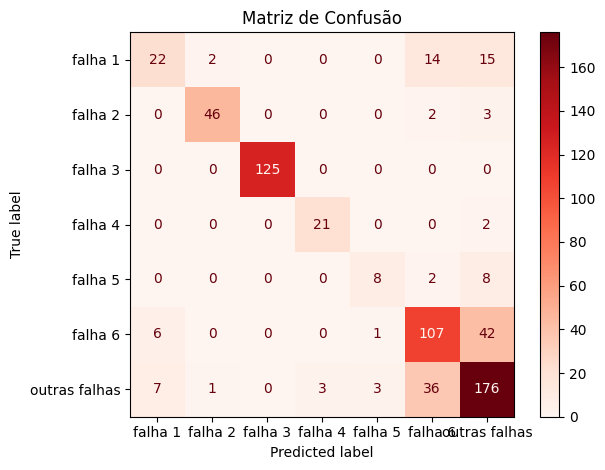

In [345]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=customizar["falha"])

disp.plot(cmap="Reds")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

In [346]:
y_numerico = le.fit_transform(y)
cvs = cross_val_score(xgb_clf, X, y_numerico, cv=10, scoring="accuracy")

print(f"\nAcurácia da Validação Cruzada: {cvs}")
print(f"\nAcurácia Média CV: {np.mean(cvs):.4f}")
print(f"\nAcurácia Padrão CV: {np.std(cvs):.4f}")


Acurácia da Validação Cruzada: [0.81595092 0.80981595 0.82208589 0.84355828 0.79447853 0.74539877
 0.76380368 0.73619632 0.72923077 0.68307692]

Acurácia Média CV: 0.7744

Acurácia Padrão CV: 0.0482


# Teste

Testar o modelo para identificar as falhas

### Analisar o arquivo para teste para ver se não há nenhuma inconsistência

In [347]:
tabela_test = pd.read_csv("bootcamp_test.csv")

In [348]:
tabela_test.shape

(389, 32)

In [349]:
tabela_test.sample(10)

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,...,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade
345,3735,827,834,1930709,1930720,100,56,11,11,6337,...,-0.330298,0.320540,1.0,1.7482,0.8451,1.0414,0.3636,-0.1159,0.1822,97
369,3759,1589,1598,2493647,2493675,100,190,21,28,18416,...,0.127418,0.773425,1.0,2.2787,0.9542,1.4472,0.6786,-0.2428,0.4170,81
43,3433,51,61,585861,585888,100,139,21,27,8233,...,0.233070,0.132756,1.0,2.1430,1.0000,1.4314,0.6296,-0.5373,0.4465,40
343,3733,702,725,1715826,1715848,100,333,28,27,35740,...,0.541327,0.263236,0.0,2.5224,1.3617,1.3424,-0.0435,-0.1615,0.7955,91
294,3684,1177,1195,3120281,3120291,100,107,27,11,10136,...,0.094583,-0.223290,0.0,2.0294,1.2553,1.0000,-0.4444,-0.2599,0.3068,81
154,3544,39,216,2648545,2648612,100,6309,269,140,660758,...,0.321147,-0.337804,0.0,3.8000,2.2480,1.8261,-0.6215,-0.1818,1.0000,45
159,3549,1573,1591,3116210,3116226,100,99,35,20,10357,...,-0.222860,0.055221,0.0,1.9956,1.2553,1.2041,-0.1111,-0.1827,0.4763,97
44,3434,41,197,1959683,1959850,100,11411,801,433,1303229,...,0.268098,0.510031,1.0,4.0573,2.1931,2.2227,0.0659,-0.1077,1.0000,40
289,3679,0,17,177337,177387,100,353,53,56,32335,...,0.038099,0.031780,1.0,2.5478,1.2305,1.6990,0.6600,-0.2844,0.9747,79
257,3647,193,205,82308,82319,100,84,19,11,9155,...,-0.185186,0.048826,0.0,1.9243,1.0792,1.0414,-0.0833,-0.1485,0.2432,99


In [350]:
tabela_test.tail()

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,...,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade
384,3774,1295,1308,4061997,4062020,100,138,25,25,7331,...,0.015657,0.398362,1.0,2.1399,1.1139,1.3617,0.4348,-0.5850,0.4946,21
385,3775,39,192,29559,29611,100,4915,248,153,497404,...,-0.185390,0.817459,0.0,3.6915,2.1847,1.7160,-0.6601,-0.2094,1.0000,33
386,3776,41,213,1637218,1637282,100,6206,257,128,641502,...,0.102096,0.002255,0.0,3.7928,2.2355,1.8062,-0.6279,-0.1924,1.0000,39
387,3777,39,172,334925,334972,100,4123,177,90,426267,...,-0.147991,0.272513,0.0,3.6152,2.1239,1.6721,-0.6466,-0.1923,1.0000,40
388,3778,1293,1316,600561,600841,100,2643,170,285,271889,...,0.393246,0.569895,1.0,3.4221,1.3617,2.4472,0.9179,-0.1963,1.0000,44


In [351]:
display(tabela_test.isnull().sum())

id                              0
x_minimo                        0
x_maximo                        0
y_minimo                        0
y_maximo                        0
peso_da_placa                   0
area_pixels                     0
perimetro_x                     0
perimetro_y                     0
soma_da_luminosidade            0
maximo_da_luminosidade          0
comprimento_do_transportador    0
tipo_do_aço_A300                0
tipo_do_aço_A400                0
espessura_da_chapa_de_aço       0
temperatura                     0
index_de_bordas                 0
index_vazio                     0
index_quadrado                  0
index_externo_x                 0
indice_de_bordas_x              0
indice_de_bordas_y              0
indice_de_variacao_x            0
indice_de_variacao_y            0
indice_global_externo           0
log_das_areas                   0
log_indice_x                    0
log_indice_y                    0
indice_de_orientaçao            0
indice_de_lumi

### Remover as colunas que não serão usadas nas predições

In [352]:
tabela_test = tabela_test.drop(["id", "y_minimo", "y_maximo", "peso_da_placa"], axis=1)

In [353]:
tabela_test.shape

(389, 28)

In [354]:
tabela_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   x_minimo                      389 non-null    int64  
 1   x_maximo                      389 non-null    int64  
 2   area_pixels                   389 non-null    int64  
 3   perimetro_x                   389 non-null    int64  
 4   perimetro_y                   389 non-null    int64  
 5   soma_da_luminosidade          389 non-null    int64  
 6   maximo_da_luminosidade        389 non-null    int64  
 7   comprimento_do_transportador  389 non-null    int64  
 8   tipo_do_aço_A300              389 non-null    int64  
 9   tipo_do_aço_A400              389 non-null    int64  
 10  espessura_da_chapa_de_aço     389 non-null    int64  
 11  temperatura                   389 non-null    float64
 12  index_de_bordas               389 non-null    float64
 13  index

In [355]:
print(f"Tipo do aço A300: {tabela_test["tipo_do_aço_A300"].unique()}")
print(f"Tipo do aço A400: {tabela_test["tipo_do_aço_A400"].unique()}")

Tipo do aço A300: [1 0]
Tipo do aço A400: [0 1]


### Remover os dados negativos
Dados negativos podem ser sensore com defeito ou processamento de dados incorretos

In [356]:
tabela_test = tabela_test.abs()

In [357]:
tabela_test.sample(10)

,x_minimo,x_maximo,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,maximo_da_luminosidade,comprimento_do_transportador,tipo_do_aço_A300,tipo_do_aço_A400,...,indice_de_variacao_x,indice_de_variacao_y,indice_global_externo,log_das_areas,log_indice_x,log_indice_y,indice_de_orientaçao,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade
104,1097,1114,238,62,41,27036,134,1362,1,0,...,0.004531,0.409933,1.0,2.3766,1.2305,1.5185,0.4848,0.1125,0.8488,96
220,145,159,63,20,15,7752,140,1354,1,0,...,0.598729,0.232085,0.0,1.7993,1.1461,1.0792,0.1429,0.0387,0.2901,109
268,375,384,209,24,31,24034,143,1692,1,0,...,0.190219,0.153055,1.0,2.3201,0.9542,1.4914,0.7097,0.1016,0.4613,90
345,827,834,56,11,11,6337,132,1356,0,1,...,0.330298,0.320540,1.0,1.7482,0.8451,1.0414,0.3636,0.1159,0.1822,97
20,214,247,209,66,46,27037,143,1362,0,1,...,0.342400,0.501341,0.0,2.3201,1.5185,1.1761,0.5454,0.0106,0.7833,118
90,260,272,55,12,7,6106,124,1356,1,0,...,0.040477,0.153333,0.0,1.7404,1.0792,0.8451,0.4167,0.1327,0.1892,101
237,39,214,13601,805,503,1579135,141,1400,0,1,...,0.065498,0.180298,1.0,4.1336,2.2430,2.2672,0.0540,0.0929,1.0000,25
172,1221,1232,90,17,11,9216,124,1362,0,1,...,0.020976,0.161902,0.5,1.9542,1.0414,1.0414,0.0000,0.2000,0.2300,85
14,39,200,6181,209,117,638448,127,1356,0,1,...,0.147456,0.166401,0.0,3.7911,2.2068,1.7993,0.6087,0.1930,1.0000,44
365,51,172,3671,175,89,379850,124,1360,0,1,...,0.756667,0.142910,0.0,3.5648,2.0828,1.6721,0.6116,0.1916,1.0000,46


In [358]:
tabela_test["tipo_aço"] = tabela_test[colunas_aco].idxmax(axis=1)
tabela_test = tabela_test.drop(columns=colunas_aco)

In [359]:
tabela_test.shape

(389, 27)

In [360]:
X_test = tabela_test

In [361]:
y_test_pred = xgb_clf.predict(X_test)

In [362]:
tabela_test["previsao_falha"] = y_test_pred

In [363]:
tabela_test["previsao_falha"].sample(10)

216    6
286    6
153    6
174    6
279    5
150    6
84     1
16     0
278    6
327    6
Name: previsao_falha, dtype: int64

### Random Florest

#### Foi criado outro modelo para comparar com os resultados do primeiro

In [364]:
rf = Pipeline(steps=[
    ("precessando", preprocessor),
    ("classificar", RandomForestClassifier(random_state=42))
])

In [365]:
%%time
rf.fit(X_train, y_train)

CPU times: total: 2.16 s
Wall time: 2.58 s


Pipeline(steps=[('precessando',
                 ColumnTransformer(transformers=[('falha', StandardScaler(),
                                                  ['x_minimo', 'x_maximo',
                                                   'area_pixels', 'perimetro_x',
                                                   'perimetro_y',
                                                   'soma_da_luminosidade',
                                                   'maximo_da_luminosidade',
                                                   'comprimento_do_transportador',
                                                   'espessura_da_chapa_de_aço',
                                                   'temperatura',
                                                   'index_de_bordas',
                                                   'index_vazio',
                                                   'index_quadrado',
                                                   'index_externo_x',
                                                   'indice_de_bordas_x',
                                                   'indice_de_bordas_y',
                                                   'indice_de_variacao_x',
                                                   'indice_de_variacao_y',
                                                   'log_das_areas',
                                                   'log_indice_x',
                                                   'log_indice_y',
                                                   'indice_de_orientaçao',
                                                   'indice_de_luminosidade',
                                                   'sigmoide_das_areas',
                                                   'minimo_da_luminosidade'])])),
                ('classificar', RandomForestClassifier(random_state=42))])

### Pelo que consta os dois modelos tiveram os mesmos resultados

In [366]:
print(classification_report(y_test, y_pred, target_names=customizar["falha"]))

               precision    recall  f1-score   support

      falha 1       0.63      0.42      0.50        53
      falha 2       0.94      0.90      0.92        51
      falha 3       1.00      1.00      1.00       125
      falha 4       0.88      0.91      0.89        23
      falha 5       0.67      0.44      0.53        18
      falha 6       0.66      0.69      0.68       156
outras falhas       0.72      0.78      0.75       226

     accuracy                           0.77       652
    macro avg       0.78      0.73      0.75       652
 weighted avg       0.77      0.77      0.77       652

